DATA ANALYTICS
---
Wanderson
---



![image.png](attachment:image.png)

PUBG:
---
PUBG é a sigla para PlayerUnknown's Battlegrounds, o jogo de tiro que atualmente é um fenômeno no mundo inteiro, já ultrapassou a marca de 3 milhões de jogadores online em um período de 30 dias na Steam (versão para PC).
O jogo traz o conceito de um Battle Royale, onde diversas pessoas entram num vasto campo de batalha, desarmados e sem mantimentos, e terão que buscar itens e armas para batalhar em uma cenário onde apenas um sairá vivo e declarado vencedor.

Informações do Kaggle para a Competição:
---

Em um jogo PUBG, até 100 jogadores começam em cada partida (matchId). Os jogadores podem estar em equipes (groupId) que são classificadas no final do jogo (winPlacePerc) com base em quantas outras equipes ainda estão vivas quando são eliminadas. No jogo, os jogadores podem pegar munições diferentes, reviver companheiros de equipe abatidos, mas não expulsos (nocautes), dirigir veículos, nadar, correr, atirar e experimentar conseqüências de todas as suas ações.
Foram disponibilizados um grande número de estatísticas de jogos anônimos, formatados para que cada linha contenha as estatísticas pós-jogo de um jogador. 
Os dados correspondem a todos os tipos de jogos possíveis: solos, duos, esquadrões e customizados. Cada partida possui no máximo 100 jogadores, cada esquadrão (squad) possui no máximo 4 jogadores por grupo.

O Desafio é criar um modelo que preveja a colocação final dos jogadores com base em suas estatísticas finais, em uma escala de 1 (primeiro lugar) a 0 (último lugar).
fontes: 
https://www.redbull.com/br-pt/o-que-e-pubg
  https://www.kaggle.com/c/pubg-finish-placement-prediction/data

Descrição do conjuto de dados
---
Data fields:

DBNOs - Number of enemy players knocked.

assists - Number of enemy players this player damaged that were killed by teammates.

boosts - Number of boost items used.

damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.

headshotKills - Number of enemy players killed with headshots.

heals - Number of healing items used.

Id - Player’s Id

killPlace - Ranking in match of number of enemy players killed.

killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.

killStreaks - Max number of enemy players killed in a short amount of time.

kills - Number of enemy players killed.

longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

matchDuration - Duration of match in seconds.

matchId - ID to identify match. There are no matches that are in both the training and testing set.

matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.

rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.

revives - Number of times this player revived teammates.

rideDistance - Total distance traveled in vehicles measured in meters.

roadKills - Number of kills while in a vehicle.

swimDistance - Total distance traveled by swimming measured in meters.

teamKills - Number of times this player killed a teammate.

vehicleDestroys - Number of vehicles destroyed.

walkDistance - Total distance traveled on foot measured in meters.

weaponsAcquired - Number of weapons picked up.

winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

numGroups - Number of groups we have data for in the match.

maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

## Construção do FrameWork

### Instalação das Bibliotecas

In [ ]:
!pip install matplotlib
!pip install missingno
!pip install findspark
!pip install pyspark
!pip install seaborn
!pip install numpy
!pip install pandas

### Inicializando o Sessão do Spark


In [ ]:
#Iniciando ambiente do spark
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder \
                    .appName("XxX") \
                    .getOrCreate()

#Bibliotecas de funcoes genéricas
import pyspark.sql.functions as F  
from pyspark.sql.types import *

#Biblioteca para transfomação dos dados.(Dataframe para único vetor)
from pyspark.ml.feature import VectorAssembler

#Bibliotecas para normalização dos dados
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import MaxAbsScaler

#Bibliotecas para análise PCA
from pyspark.ml.feature import PCA

#Funções utilizadas: Correlação
from pyspark.mllib.stat import Statistics

#Bibliotecas dos estimadores
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder,TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.regression import IsotonicRegression
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

### Chamada das bibliotecas

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import missingno as msno #Gráficos para availação de valores faltantes (NULLs e NANs)
import seaborn as sns #Plotagem de gráficos
import gc #Liberar memória
import numpy as np
from functools import reduce
import random
sns.set(style="darkgrid")

### Lendo dataframe com spark DataFrame a partir de uma pasta do GoogleDrive

In [ ]:
df = spark.read.csv('C:/Users/Nando/Google Drive/Colab Notebooks/Dados_HandsOn/train_V2.csv', header=True, inferSchema=True)
df.persist()
print(df.count())

4446966


### Identificando a estrutura da base

In [ ]:
df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- groupId: string (nullable = true)
 |-- matchId: string (nullable = true)
 |-- assists: integer (nullable = true)
 |-- boosts: integer (nullable = true)
 |-- damageDealt: double (nullable = true)
 |-- DBNOs: integer (nullable = true)
 |-- headshotKills: integer (nullable = true)
 |-- heals: integer (nullable = true)
 |-- killPlace: integer (nullable = true)
 |-- killPoints: integer (nullable = true)
 |-- kills: integer (nullable = true)
 |-- killStreaks: integer (nullable = true)
 |-- longestKill: double (nullable = true)
 |-- matchDuration: integer (nullable = true)
 |-- matchType: string (nullable = true)
 |-- maxPlace: integer (nullable = true)
 |-- numGroups: integer (nullable = true)
 |-- rankPoints: integer (nullable = true)
 |-- revives: integer (nullable = true)
 |-- rideDistance: double (nullable = true)
 |-- roadKills: integer (nullable = true)
 |-- swimDistance: double (nullable = true)
 |-- teamKills: integer (nullable = true)
 |--

### Convertendo os tipos de dados de cada atributo
Para esse conjunto de dados a inferencia de tipos do PySpark foi assertiva. Não foi necessário ajustar o tipo dos atributos.

In [ ]:
#ENTRADA MANUAL: Indicar o tipo de dado desejado para cada atributo na mesma ordem do dataframe
desiredColTypes = [StringType(),\
                   StringType(),  \
                   StringType(),  \
                   IntegerType(),  \
                   IntegerType(),  \
                   FloatType(),   \
                   StringType(),  \
                   StringType(), \
                   StringType(), \
                   FloatType(),  \
                   StringType(), \
                   StringType() ]

#Verifica se o tamanho do vetor de tipos é igual a quantidade de atributos
if len(desiredColTypes)==len(df.columns):
    for i in range(0,len(df.columns)): 
        df = df.withColumn(df.columns[i], df[df.columns[i]].cast(desiredColTypes[i]))
else:
    print("Verificar tipo de dados desejados. Quantidade menor que a quantidade de colunas")

df.printSchema()

### Verificando a quantidade de nulos de cada atributo

7

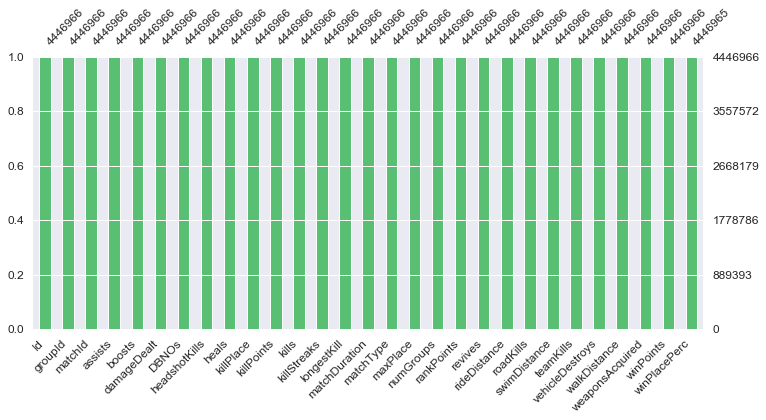

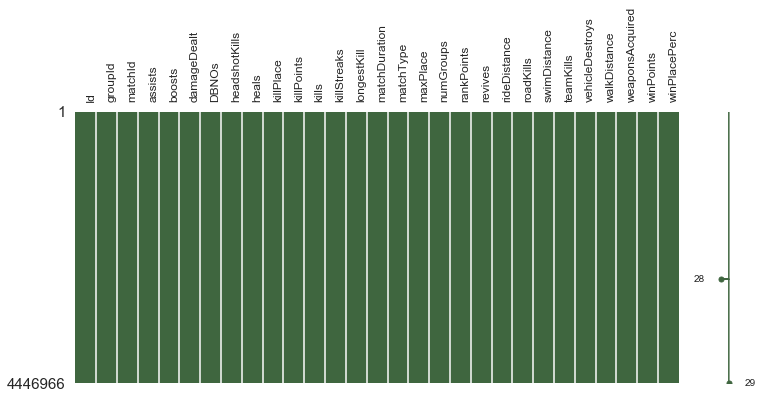

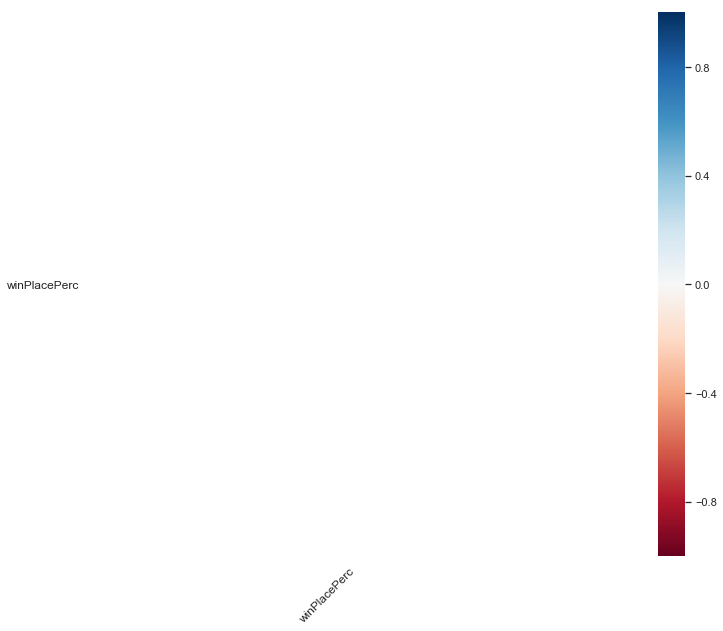

In [ ]:
aux = df.toPandas()
msno.bar(aux, figsize=(12,5), fontsize=12,color=(0.35, 0.75, 0.45))
msno.matrix(aux, figsize=(12,5), fontsize=12, color=(0.25, 0.4, 0.25),sparkline=True)
msno.heatmap(aux, figsize=(12,10), fontsize=12)
aux=None
gc.collect()

### Analisando cada atributo

In [ ]:
#Funcão para gerar valores aleatórios
def randomvals(valmin, valmax, seed,valtype):
    np.random.seed(0)
    if valtype=='IntegerType':
        return round(np.random.uniform(valmin,valmax),2)
    else:
        return round(np.random.uniform(valmin,valmax)+np.random.rand(),2)
    
#Valores para eixo X do scatter plot
x = np.array(range(0,df.count()))

#Loop para substituir outliers (IQR) por valores aleatórios entre media e 1 desvio padrão.
for col in df.columns:

    #Verificando tipo de dado do atributo
    if((str(df.schema[col].dataType)=='IntegerType') | (str(df.schema[col].dataType)=='DoubleType') | (str(df.schema[col].dataType)=='FloatType')):
        
        #Para debug
        print(col," Tipo: ",df.schema[col].dataType," - ok")
        
        #Criando dataset pandas auxiliar para plotar gráficos
        df_aux = df.select(col).toPandas()
        
        #Criando figure para plot e definindo titulo
        fig = plt.figure(figsize=(18,10));
        fig.suptitle('%s - Numérico' % col, fontsize=16)
        
        #Gerando gráfico boxplot
        ax1 = plt.subplot2grid((10, 8), (0, 0), colspan=4,rowspan=2)
        df_aux.boxplot(grid=False, fontsize=10, vert=False,sym='r+',showmeans=True, meanline=True,widths=0.5, boxprops=dict(linewidth=2), medianprops=dict(linewidth=2.5))
        ax1.set_title('Dados Originais',fontsize = 16)
        
        #Gerando histograma
        ax2 = plt.subplot2grid((10, 8), (2, 0), colspan=4,rowspan=3)
        ax2.hist(np.array(df_aux), bins=30)

        #Fazendo um plot da distrubição dos dados no tempo
        ax3 = plt.subplot2grid((10, 8), (5, 0), colspan=4,rowspan=3)
        ax3.scatter(x,df_aux,color='r', marker='+')
        
        #Inserindo dados de estatistica descritiva dos dados
        ax4 = plt.subplot2grid((10, 8), (8, 0), colspan=1,rowspan=2)
        ax4.set_axis_off()
        ax4.text(0, 0.5, df.describe(col).withColumn(col, F.round(col, 2)).toPandas().to_string(index = False,header=False) , fontsize=15, verticalalignment='center')
        
        #Fazendo o cálculo dos quartis
        bounds = df.approxQuantile(col, [0.25,0.5, 0.75], 0)
        IQR = bounds[2] - bounds[0]
        minVal = bounds[0] - IQR*1.2
        maxVal = bounds[1] + IQR*1.2
        
        #Calculando mediana e desvio padrão do atributo
        median = bounds[1]
        stddev = df.agg({col: 'std'}).collect()

        #Definindo range para gerar os valores aleatórios
        valmin = median-stddev[0][0]
        valmax = median+stddev[0][0]
        valtype = str(df.schema[col].dataType)
        
        #Substituindo os valores no dataFrame de acordo com limites por valores aleatórios dentro da faixa definida
        #Atualizando o dataframe auxiliar com os dados com tratamento dos outliers
        df_aux = df.withColumn(col, F.when( (df[col]>maxVal) | (df[col]<minVal), randomvals(valmin,valmax,0,valtype)).otherwise(df[col]))
        df_aux1 = df_aux.select(col).toPandas()
        
        #Gerando gráfico boxplot
        ax5 = plt.subplot2grid((10, 8), (0, 4), colspan=4,rowspan=2)
        df_aux1.boxplot(grid=False, fontsize=10, vert=False,sym='r+',showmeans=True, meanline=True,widths=0.5, boxprops=dict(linewidth=2), medianprops=dict(linewidth=2.5))
        ax5.set_title('Outliers Tratados',fontsize = 16)
        
        #Gerando histograma
        ax6 = plt.subplot2grid((10, 8), (2, 4), colspan=4,rowspan=3)
        ax6.hist(np.array(df_aux1), bins=30)

        #Fazendo um plot da distrubição dos dados no tempo
        ax7 = plt.subplot2grid((10, 8), (5, 4), colspan=4,rowspan=3)
        ax7.scatter(x,df_aux1,color='r', marker='+')
        
        #Inserindo dados de estatistica descritiva dos dados
        ax8 = plt.subplot2grid((10, 8), (8, 4), colspan=1,rowspan=2)
        ax8.set_axis_off()
        ax8.text(0, 0.5, df_aux.describe(col).withColumn(col, F.round(col, 2)).toPandas().to_string(index = False,header=False) , fontsize=15, verticalalignment='center')
        
        #Ajustando as bordas dos gráficos
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        
    elif(str(df.schema[col].dataType)=='StringType'):
    
        if (df.groupBy(col).count().count()<20):
    
            #Criando figure para plot e definindo titulo
            fig = plt.figure(figsize=(10,5));
            ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=3,rowspan=3)
            ax1.set_title('%s - Categórico' % col,fontsize = 16)
      
            #Contando os valores de cada categoria
            data = df.groupBy(col).count().fillna('SemValores').toPandas().sort_values(by='count', ascending=False)
            labels = np.array(data[col])
            vals = np.array(data['count'])
            
            #Inserindo marcações do eixo X com rotação 
            bars = ax1.bar(labels,vals,0.5, align='center')
            plt.xticks(rotation=90)
            
            #Inserindo texto da contagem em cada barra do gráfico
            for rect in bars:
                height = rect.get_height()
                plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom',fontweight='bold')
            
        else:
            print('Atributo:', col, 'Categorias: ',df.groupBy(col).count().count(),' - Alta quantidade de categorias.Reavaliar vizualização.')
    
    elif (str(df.schema[col].dataType)=='DateType'):
        print("EM DESENVOLVIMENTO")

Atributo: Id Categorias:  4446966  - Alta quantidade de categorias.Reavaliar vizualização.
Atributo: groupId Categorias:  2026745  - Alta quantidade de categorias.Reavaliar vizualização.
Atributo: matchId Categorias:  47965  - Alta quantidade de categorias.Reavaliar vizualização.
assists  Tipo:  IntegerType  - ok
boosts  Tipo:  IntegerType  - ok
damageDealt  Tipo:  DoubleType  - ok
DBNOs  Tipo:  IntegerType  - ok
headshotKills  Tipo:  IntegerType  - ok
heals  Tipo:  IntegerType  - ok
killPlace  Tipo:  IntegerType  - ok
killPoints  Tipo:  IntegerType  - ok
kills  Tipo:  IntegerType  - ok
killStreaks  Tipo:  IntegerType  - ok


## Pre processamento

In [ ]:
estatisticas = df.select('*').summary().toPandas()
estatisticas.head(10)

summary                  Id             groupId             matchId  \
0   count             4446966             4446966             4446966   
1    mean            Infinity            Infinity            Infinity   
2  stddev                 NaN                 NaN                 NaN   
3     min      00000160737ebf      00000c08b5be36      0000a43bce5eec   
4     25%  3.9852928402637E13  4.1333354930918E13  4.4751296165268E13   
5     50%       6.00177383E17    3.37644596673E17     9.1446802155E66   
6     75%            Infinity            Infinity            Infinity   
7     max      fffffddae4e502      fffff98178ef52      fffe92232706aa   

               assists              boosts         damageDealt  \
0              4446966             4446966             4446966   
1  0.23381492010507837  1.1069077209045448  130.71713789840615   
2   0.5885730871999957  1.7157936773815432  170.78062066696376   
3                    0                   0                 0.0   
4                    0                   0                 0.0   
5                    0                   0               84.26   
6                    0                   2               186.1   
7                   22                  33              6616.0   

                DBNOs        headshotKills               heals  ...  \
0             4446966              4446966             4446966  ...   
1  0.6578755043326169  0.22681958890623405   1.370147196987789  ...   
2  1.1457427249005605   0.6021552757837225  2.6799822305289602  ...   
3                   0                    0                   0  ...   
4                   0                    0                   0  ...   
5                   0                    0                   0  ...   
6                   1                    0                   2  ...   
7                  53                   64                  80  ...   

               revives        rideDistance              roadKills  \
0              4446966             4446966                4446966   
1  0.16465900571310868   606.1156691540915  0.0034960914924917347   
2   0.4721670982397293  1498.3435130715209    0.07337296668394434   
3                    0                 0.0                      0   
4                    0                 0.0                      0   
5                    0                 0.0                      0   
6                    0               0.248                      0   
7                   39             40710.0                     18   

         swimDistance            teamKills      vehicleDestroys  \
0             4446966              4446966              4446966   
1    4.50932245130725   0.0238684082585745  0.00791820760491535   
2  30.502199182034666  0.16739350254204888  0.09261156645325185   
3                 0.0                    0                    0   
4                 0.0                    0                    0   
5                 0.0                    0                    0   
6                 0.0                    0                    0   
7              3823.0                   12                    5   

         walkDistance     weaponsAcquired          winPoints  \
0             4446966             4446966            4446966   
1  1154.2178590962594  3.6604876223474614  606.4601305699211   
2  1183.4970417898326  2.4565436229584363  739.7004439568364   
3                 0.0                   0                  0   
4               155.2                   2                  0   
5               685.8                   3                  0   
6              1977.0                   5               1495   
7             25780.0                 236               2013   

         winPlacePerc  
0             4446965  
1  0.4728215527219376  
2  0.3074049817000348  
3                 0.0  
4                 0.2  
5              0.4583  
6              0.7407  
7                 1.0  

[8 rows x 30 columns]

### Removendo atributos
Pelas informações disponibilizadas no Kaggle sobre o atributo rankPoints,vamos desconsiderar este atrubuto do Dataset. 

**rankPoints** - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.

In [ ]:
df = df.drop('rankPoints')
df.show(1)

+--------------+--------------+--------------+-------+------+-----------+-----+-------------+-----+---------+----------+-----+-----------+-----------+-------------+---------+--------+---------+-------+------------+---------+------------+---------+---------------+------------+---------------+---------+------------+
|            Id|       groupId|       matchId|assists|boosts|damageDealt|DBNOs|headshotKills|heals|killPlace|killPoints|kills|killStreaks|longestKill|matchDuration|matchType|maxPlace|numGroups|revives|rideDistance|roadKills|swimDistance|teamKills|vehicleDestroys|walkDistance|weaponsAcquired|winPoints|winPlacePerc|
+--------------+--------------+--------------+-------+------+-----------+-----+-------------+-----+---------+----------+-----+-----------+-----------+-------------+---------+--------+---------+-------+------------+---------+------------+---------+---------------+------------+---------------+---------+------------+
|7f96b2f878858a|4d4b580de459be|a10357fd1a4a91|      

### Tratamento de valores ausentes
Conforme já explicitado anteriormente, há apenas um dado ausente no Dataset associado ao atributo winPlacePer.

In [ ]:
pd.set_option('display.max_columns', None)
df.where(F.isnull(F.col("winPlacePerc"))).toPandas().head(5)

Id         groupId         matchId  assists  boosts  \
0  f70c74418bb064  12dfbede33f92b  224a123c53e008        0       0   

   damageDealt  DBNOs  headshotKills  heals  killPlace  killPoints  kills  \
0          0.0      0              0      0          1           0      0   

   killStreaks  longestKill  matchDuration matchType  maxPlace  numGroups  \
0            0          0.0              9  solo-fpp         1          1   

   revives  rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  \
0        0           0.0          0           0.0          0                0   

   walkDistance  weaponsAcquired  winPoints winPlacePerc  
0           0.0                0          0         None

Percebe-se que o dado ausente em winPlacePerc foi de um jogador que teve a menor duração de partida (matchDuration) de todo o conjunto de dados existentes (9s). Assim, podemos desconsiderar essa instância do Dataset, sem perda de generalidade.

In [ ]:
df = df.na.drop()
pd.set_option('display.max_columns', None)
df.persist()
df.where(F.isnull(F.col("winPlacePerc"))).toPandas().head(5)

Empty DataFrame
Columns: [Id, groupId, matchId, assists, boosts, damageDealt, DBNOs, headshotKills, heals, killPlace, killPoints, kills, killStreaks, longestKill, matchDuration, matchType, maxPlace, numGroups, revives, rideDistance, roadKills, swimDistance, teamKills, vehicleDestroys, walkDistance, weaponsAcquired, winPoints, winPlacePerc]
Index: []

### Redução de classes de atributo categórico

O jogador possui diversas tipos de jogos que podem ser selecionados. O modo Padrão são constituídos por:“solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp” e “squad-fpp”.

Assim, vamos concentrar todos os outros tipos de jogos numa categoria nova chamada "Customizada".

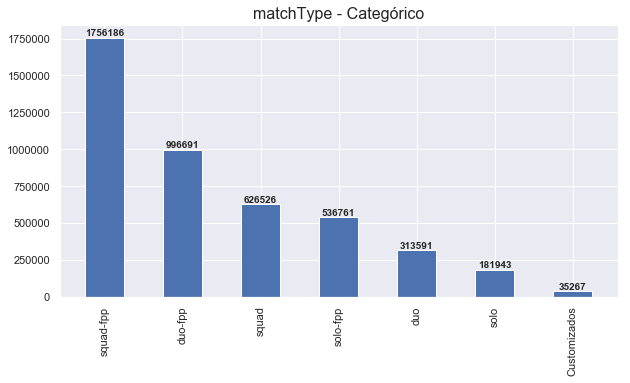

In [ ]:
#ENTRADA MANUAL: Indicar qual atributo terá suas classes agrupadas
col = 'matchType'

#Lógica de agrupamento das classes do atributo selecionado
df = df.withColumn('matchType', F.when((df[col]!='squad-fpp') & \
                                                               (df[col]!='duo-fpp') & \
                                                               (df[col]!='squad') & \
                                                               (df[col]!='solo-fpp') & \
                                                               (df[col]!='duo') & \
                                                               (df[col]!='solo') \
                                                               , 'Customizados').otherwise(df[col]))

#Criando figure para plot e definindo titulo
fig = plt.figure(figsize=(10,5));
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=3,rowspan=3)
ax1.set_title('%s - Categórico' % col,fontsize = 16)
      
#Contando os valores de cada categoria
data = df.groupBy(col).count().fillna('SemValores').toPandas().sort_values(by='count', ascending=False)
labels = np.array(data[col])
vals = np.array(data['count'])
            
#Inserindo marcações do eixo X com rotação 
bars = ax1.bar(labels,vals,0.5, align='center')
plt.xticks(rotation=90)
            
#Inserindo texto da contagem em cada barra do gráfico
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom',fontweight='bold')

### Tratamento Outliers
O tratamento dos outliers foi feito localizando os valores discrepantes pelo IQR e substituindo estes valores por valores aleatórios dentro do intervalo entre a mediana e +/- um desvio padrão do atributo. Nesse caso utizamos a substituição com a mediana no centro dos valores aleatórios para manter o perfil de distribuição dos dados.

In [ ]:
#Funcão para gerar valores aleatórios
def randomvals(valmin, valmax, seed,valtype):
    np.random.seed(0)
    if valtype=='IntegerType':
        return round(np.random.uniform(valmin,valmax),2)
    else:
        return round(np.random.uniform(valmin,valmax)+np.random.rand(),2)

df_Tratado_Out = df
#Loop para substituir outliers (IQR) por valores aleatórios entre mediana e 1 desvio padrão.
for col in df_Tratado_Out.columns:

    #Verificando tipo de dado do atributo
    if((str(df_Tratado_Out.schema[col].dataType)=='IntegerType') | (str(df_Tratado_Out.schema[col].dataType)=='DoubleType') | (str(df_Tratado_Out.schema[col].dataType)=='FloatType')):
        
        #Fazendo o cálculo dos quartis
        bounds = df_Tratado_Out.approxQuantile(col, [0.25,0.5, 0.75], 0)
        IQR = bounds[2] - bounds[0]
        minVal = bounds[0] - IQR*1.5
        maxVal = bounds[1] + IQR*1.5
        
        #Calculando mediana e desvio padrão do atributo
        median = bounds[1]
        stddev = df_Tratado_Out.agg({col: 'std'}).collect()

        #Definindo range para gerar os valores aleatórios
        valmin = median-stddev[0][0]
        valmax = median+stddev[0][0]
        valtype = str(df.schema[col].dataType)
        
        #Substituindo os valores no dataFrame de acordo com limites por valores aleatórios dentro da faixa definida
        #Atualizando o dataframe auxiliar com os dados com tratamento dos outliers
        df_Tratado_Out = df_Tratado_Out.withColumn(col, F.when( (df_Tratado_Out[col]>maxVal) | (df_Tratado_Out[col]<minVal), randomvals(valmin,valmax,0,valtype)).otherwise(df_Tratado_Out[col]))

#Alocando na memória para execução rápida nas próximas etapas
#df_Tratado.persist()

## Analise Exploratória dos dados

### Verificando atributo MatchDuration

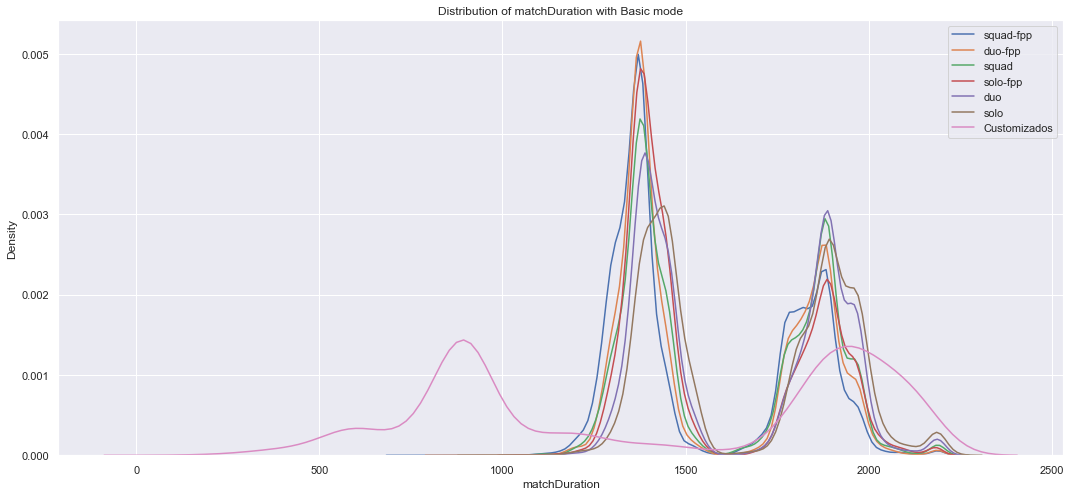

In [ ]:
#Criando DF em pandas para os plots
dfaux = df.toPandas()

#Plotando a distribuição do matchDuration para os diferentes tipos de partida
plt.figure(figsize = (18, 8))
sns.kdeplot(dfaux.loc[dfaux['matchType'] == 'squad-fpp', 'matchDuration'] , label = 'squad-fpp')
sns.kdeplot(dfaux.loc[dfaux['matchType'] == 'duo-fpp', 'matchDuration'] , label = 'duo-fpp')
sns.kdeplot(dfaux.loc[dfaux['matchType'] == 'squad', 'matchDuration'] , label = 'squad')
sns.kdeplot(dfaux.loc[dfaux['matchType'] == 'solo-fpp', 'matchDuration'] , label = 'solo-fpp')
sns.kdeplot(dfaux.loc[dfaux['matchType'] == 'duo', 'matchDuration'] , label = 'duo')
sns.kdeplot(dfaux.loc[dfaux['matchType'] == 'solo', 'matchDuration'] , label = 'solo')
sns.kdeplot(dfaux.loc[dfaux['matchType'] == 'Customizados', 'matchDuration'] , label = 'Customizados')
plt.xlabel('matchDuration'); plt.ylabel('Density'); plt.title('Distribution of matchDuration with Basic mode');

Avaliando o gráfico, percebe-se que a maioria dos jogos do tipo "Padrão" tem o mesmo perfil de duração (picos em 1400 e 1900s).  Já para os jogos customizados, o padrão de duração do jogo muda, sendo a sua grande maioria mais rápidos.

### Distribuição dos atributos numéricos por tipo de partida para os dados sem tratamento Outliers

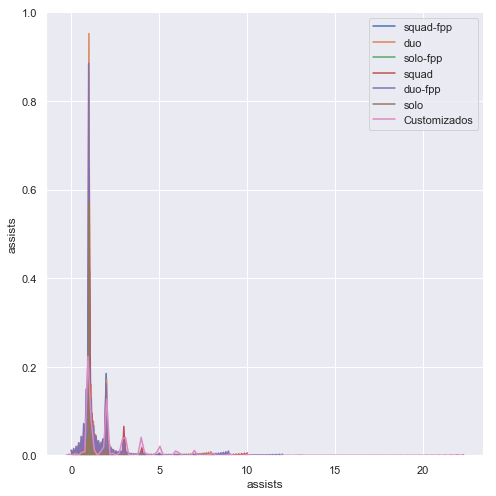

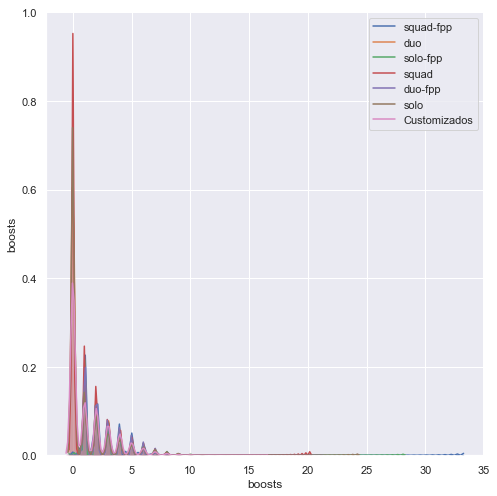

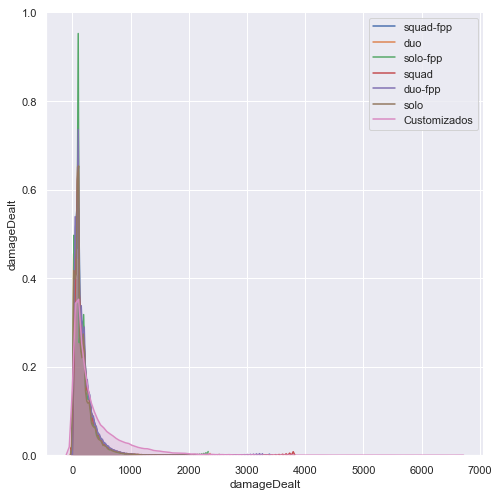

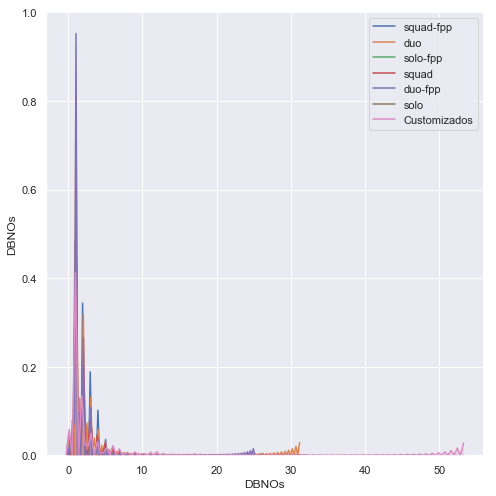

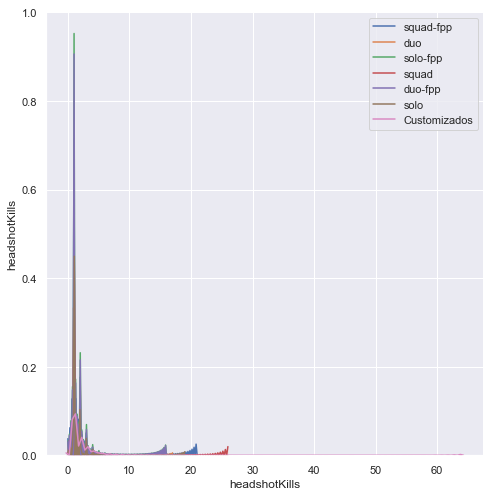

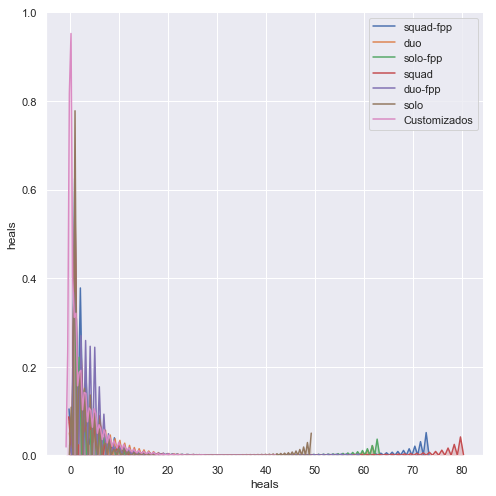

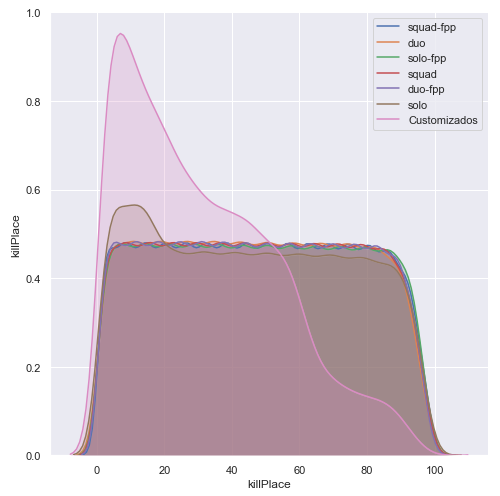

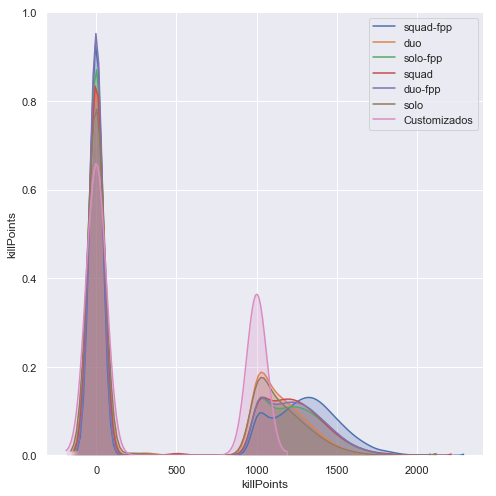

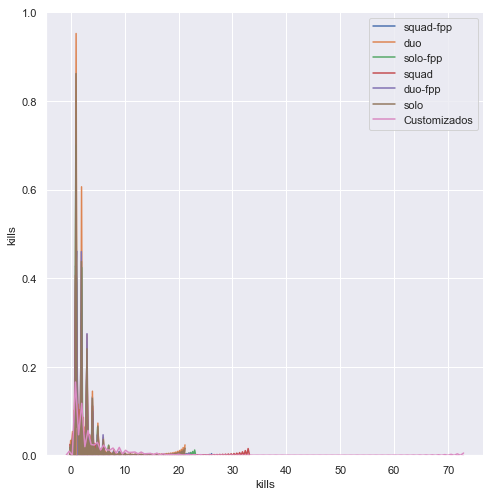

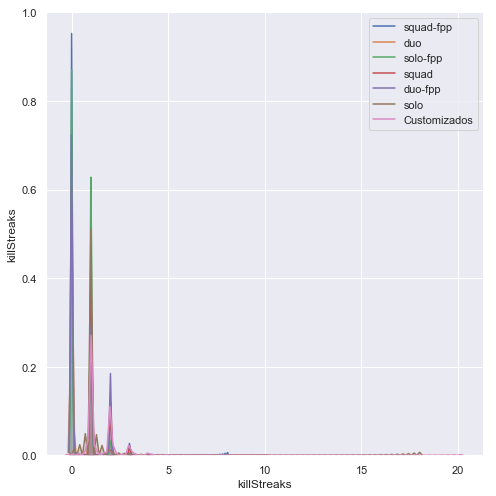

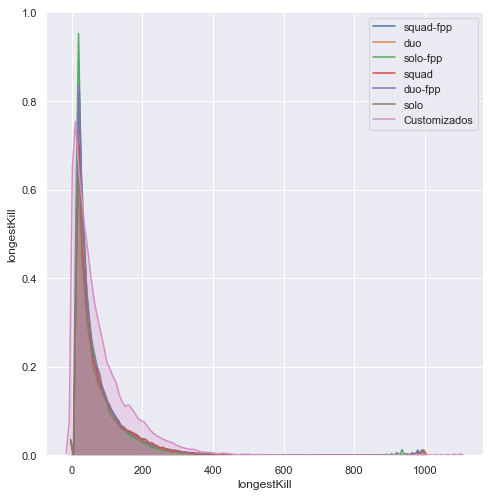

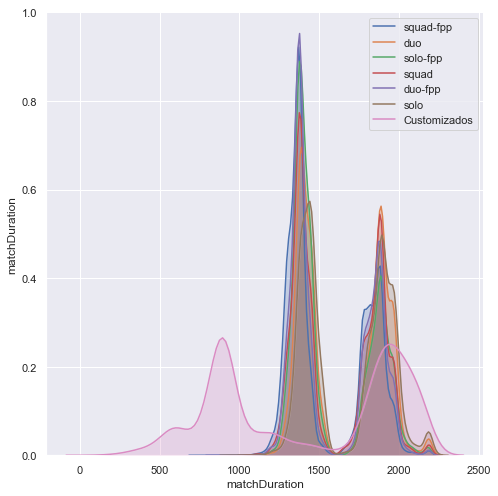

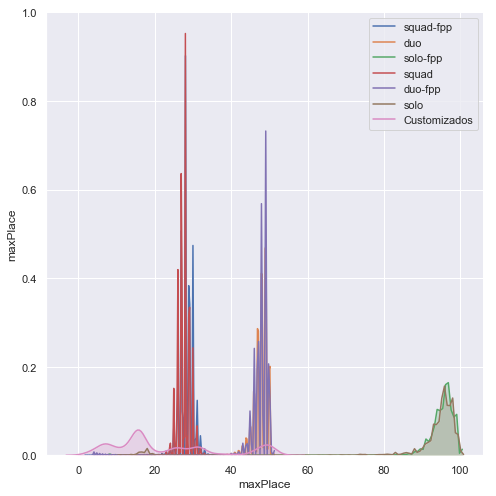

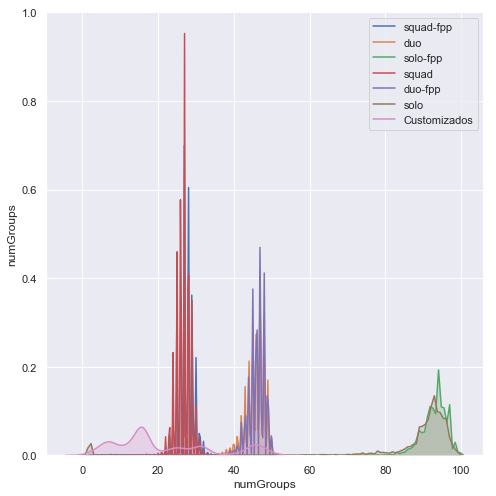

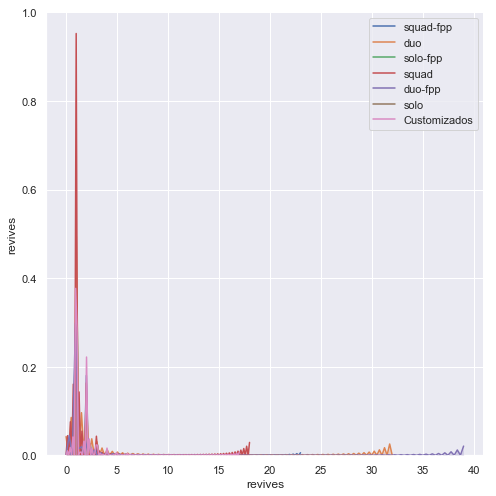

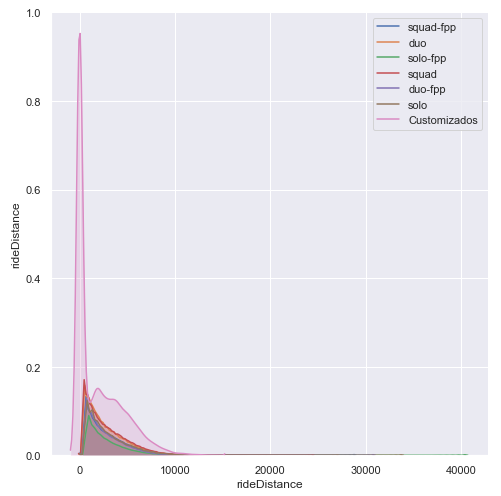

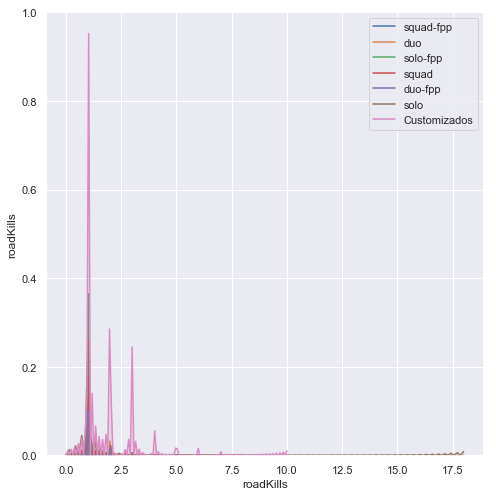

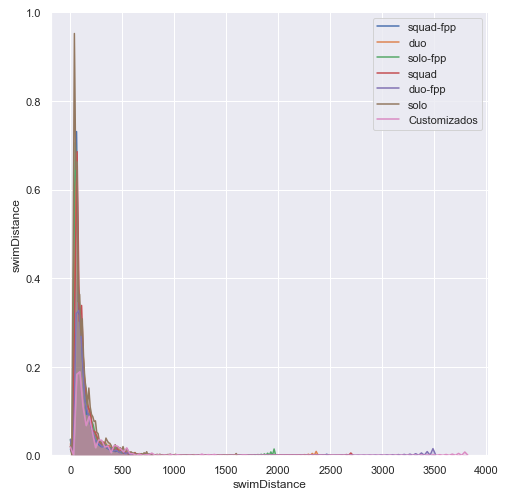

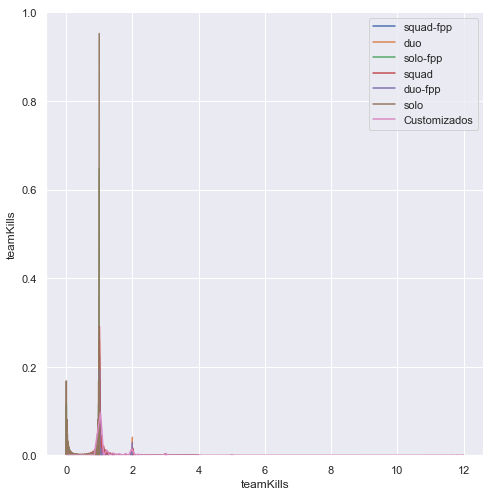

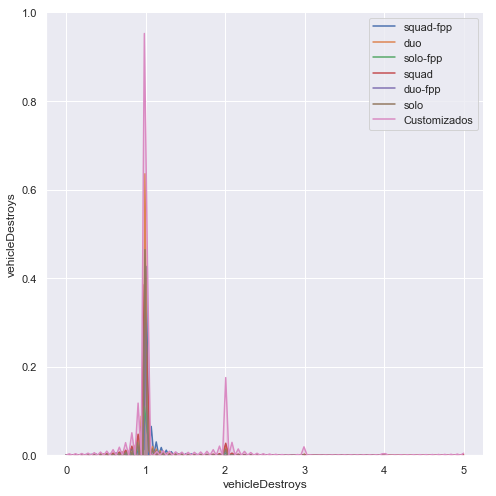

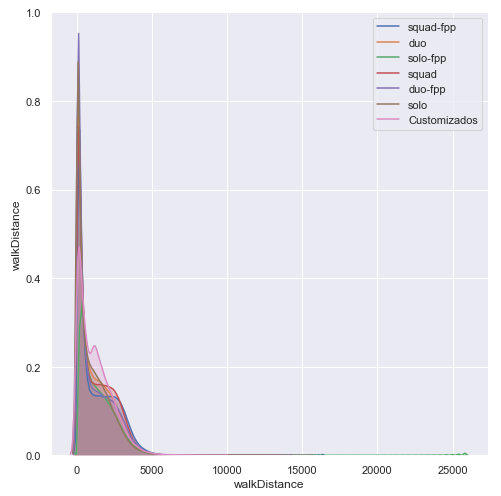

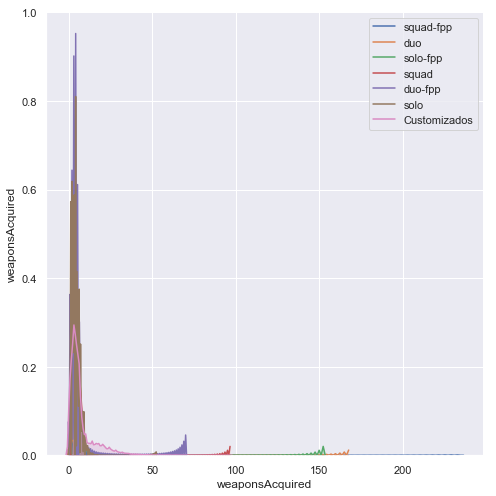

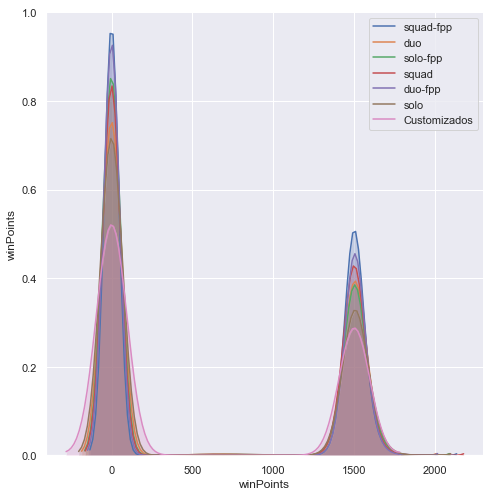

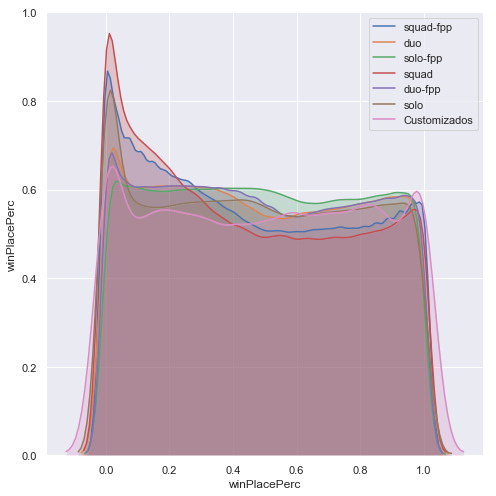

In [ ]:
#ENTRADA MANUAL: Indicar quais os atributos terão o plot segregado
#Verificando quais são as variáveis numéricas
inputCols = []
for col in df.columns:
    #Verificando tipo de dado do atributo
    if((str(df.schema[col].dataType)=='IntegerType') | (str(df.schema[col].dataType)=='DoubleType') | (str(df.schema[col].dataType)=='FloatType')):
        inputCols.append(col)
        
#ENTRADA MANUAL: Indicar qual atributo categórico será utilziado para segregar os gráficos
col = 'matchType'

#Transformando em Pandas DF para plots pelo Seaborn
df_plots = df.toPandas()

#Loop para executar os plots para todas as variáveis definidas em varplot
for i in inputCols:
    #Como o tipo de variável esperada pelo pairplot é DataFrame, convertemos cada coluna para DataFrame
    dfaux = pd.DataFrame(df_plots[[i,'matchType']])
    g = sns.pairplot(dfaux, hue="matchType",height=7)
    #Removendo a legenda do pair plot
    g._legend.remove()
    #Inserindo legenda do matplotlib
    plt.legend()

Percebe-se que os dados apresentam um mesmo perfil de distribuição para os diferentes tipos de jogo do tipo "Padrão". Já para os jogos Customizados, há para alguns atributos um comportamento ligeiramente diferente em relação as partidas padronizadas. Essa partidas customizadas ocorrem pois o fabricante do jogo pode por exemplo lançar uma partida personalizada em comemoração de uma data festiva, com regras diferentes do normal das partidas usuais.

Pela distrubuição e avaliações anteriores, é possivel notar uma grande quantidade de outliers. 

### Distribuição dos atributos numéricos por tipo de partida para os dados com tratamento Outliers

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


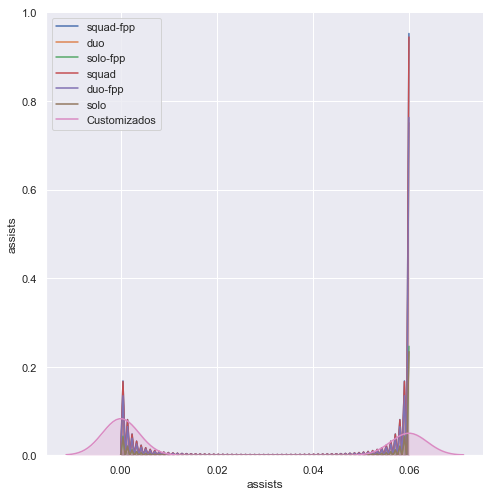

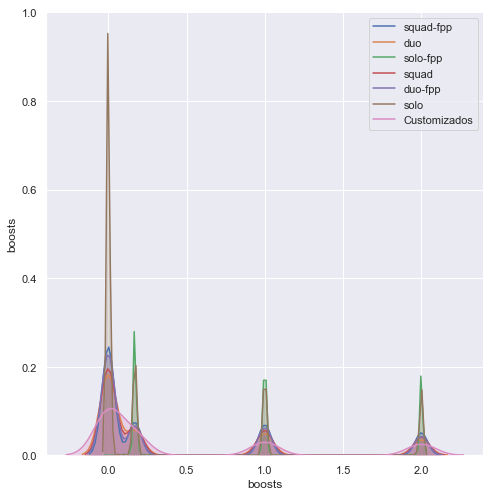

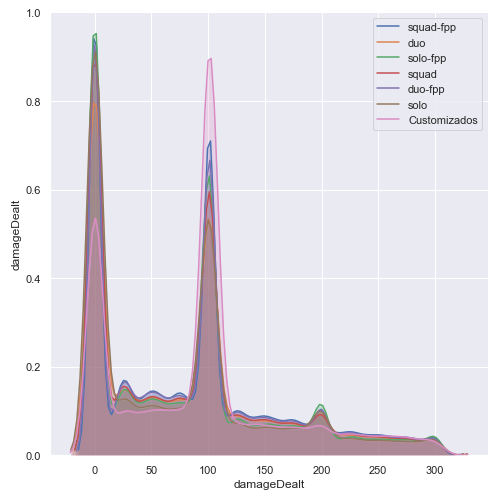

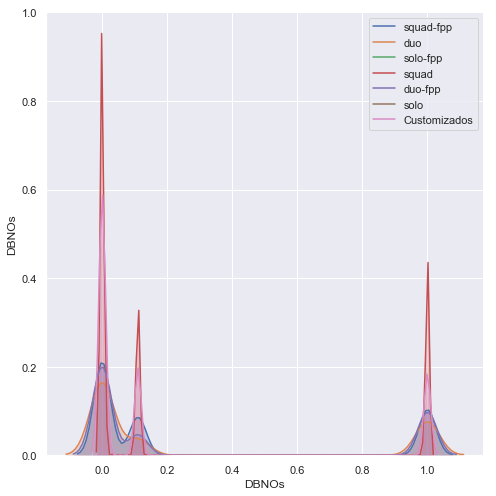

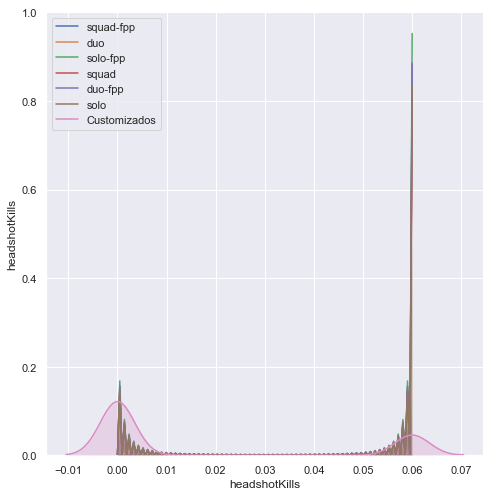

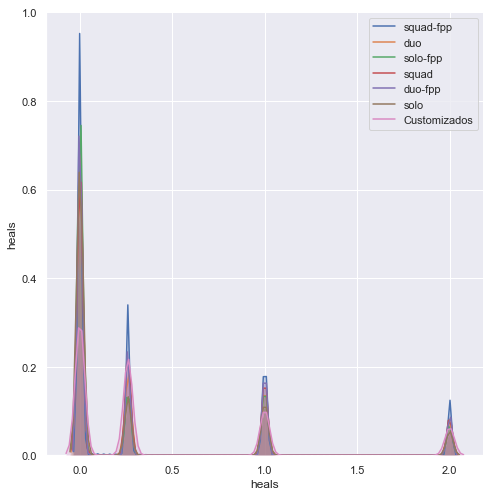

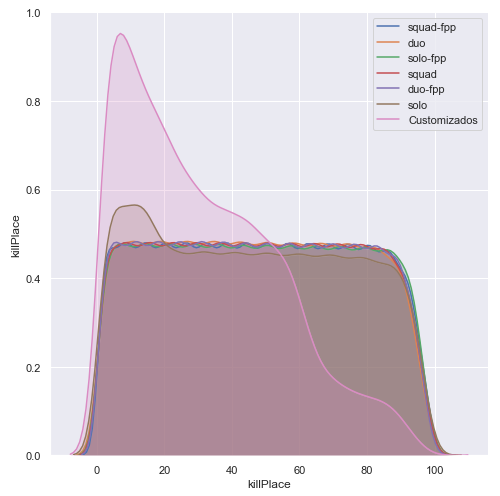

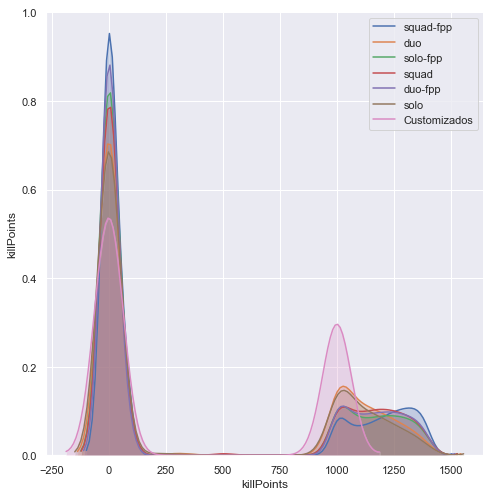

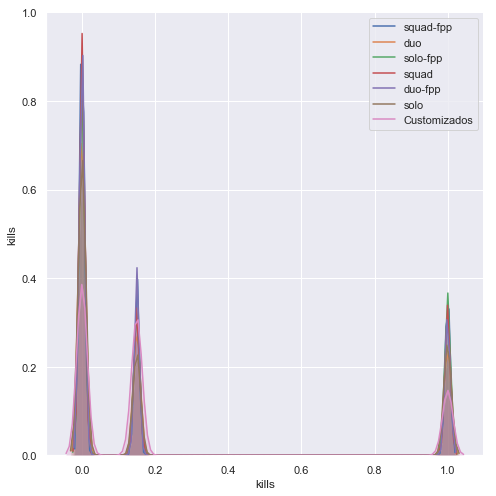

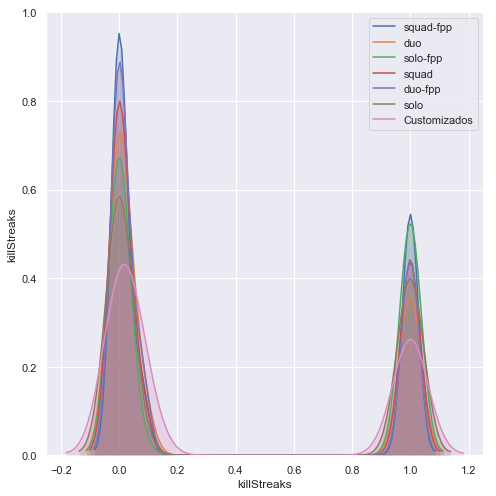

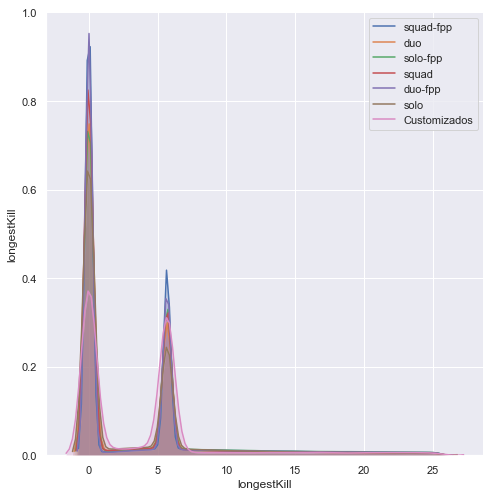

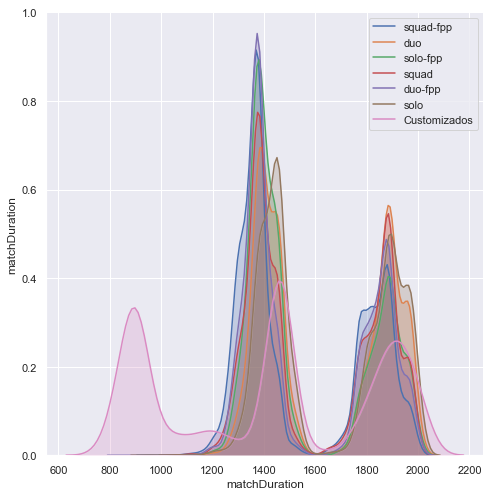

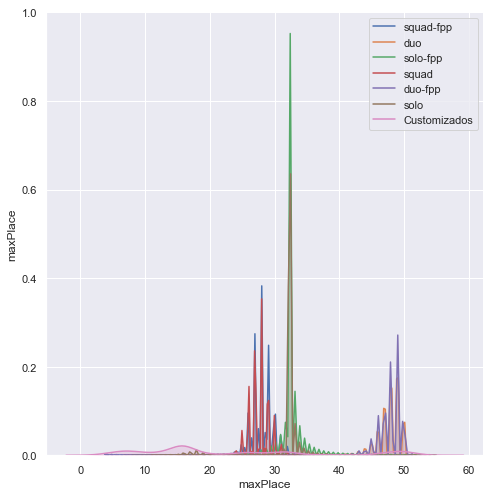

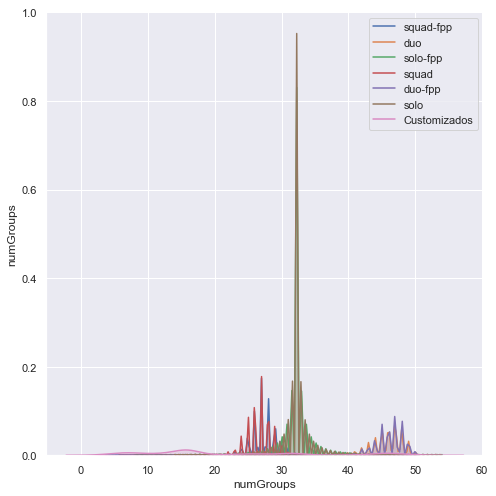

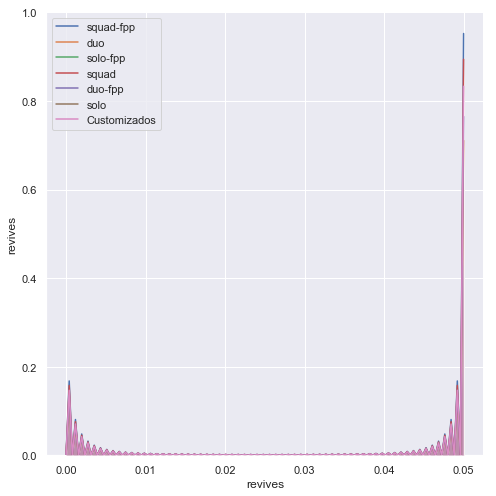

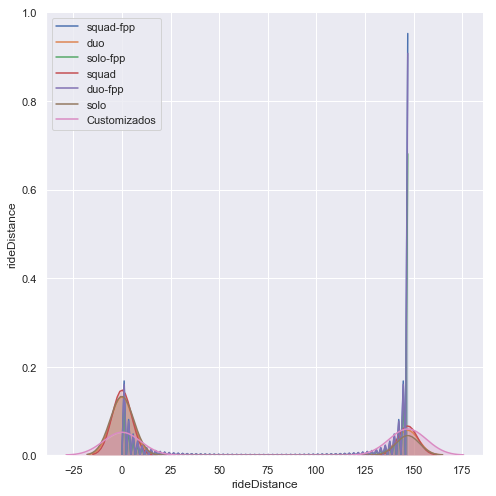

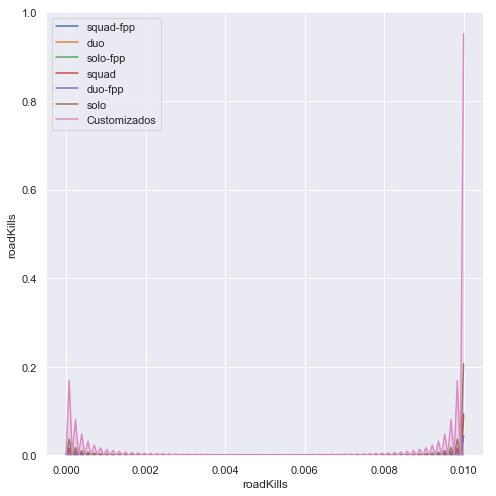

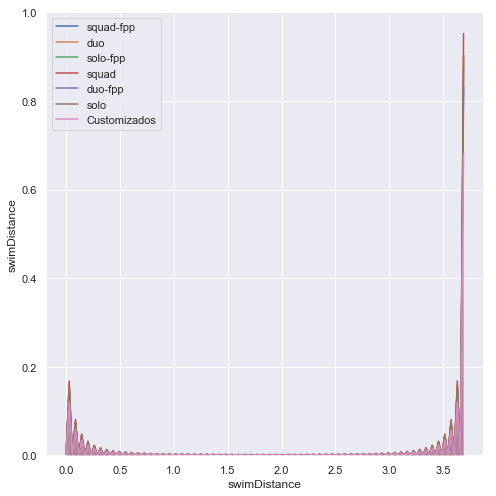

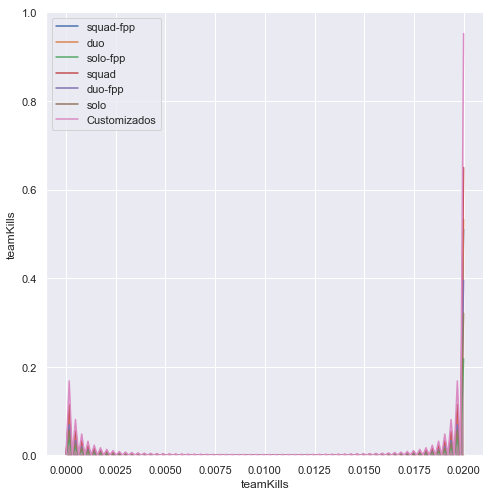

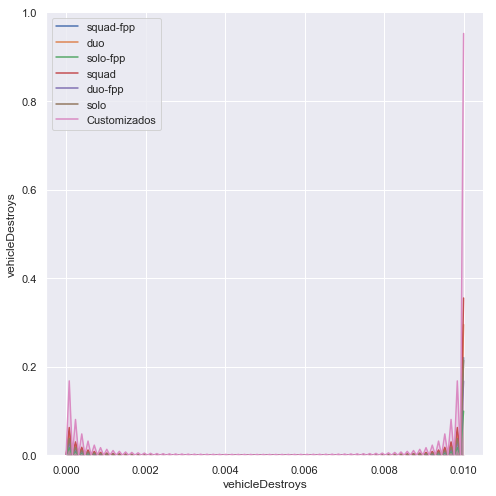

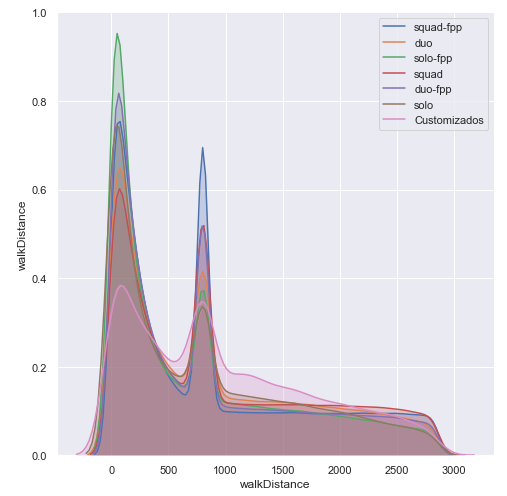

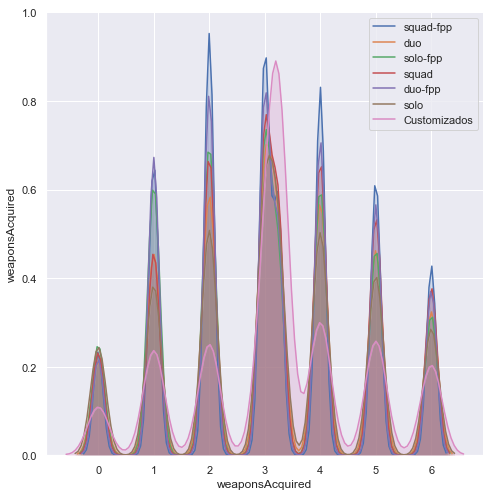

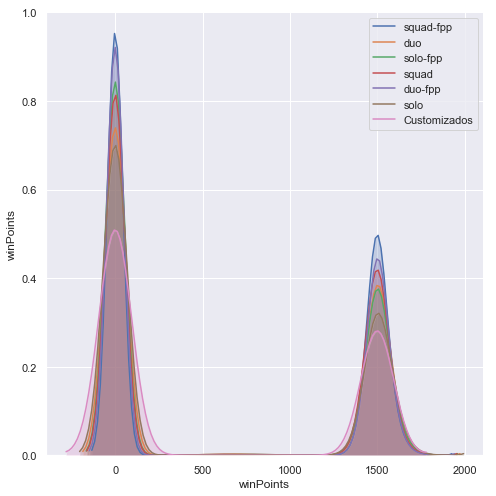

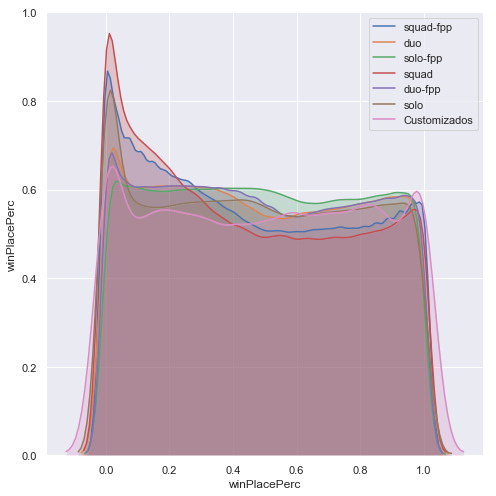

In [ ]:
#ENTRADA MANUAL: Indicar quais os atributos terão o plot segregado
#Verificando quais são as variáveis numéricas
inputCols = []
for col in df.columns:
    #Verificando tipo de dado do atributo
    if((str(df.schema[col].dataType)=='IntegerType') | (str(df.schema[col].dataType)=='DoubleType') | (str(df.schema[col].dataType)=='FloatType')):
        inputCols.append(col)
        
#ENTRADA MANUAL: Indicar qual atributo categórico será utilziado para segregar os gráficos
col = 'matchType'

#Transformando em Pandas DF para plots pelo Seaborn
df_plots = df_Tratado_Out.toPandas()

#Loop para executar os plots para todas as variáveis definidas em varplot
for i in inputCols:
    #Como o tipo de variável esperada pelo pairplot é DataFrame, convertemos cada coluna para DataFrame
    dfaux = pd.DataFrame(df_plots[[i,'matchType']])
    g = sns.pairplot(dfaux, hue="matchType",height=7)
    #Removendo a legenda do pair plot
    g._legend.remove()
    #Inserindo legenda do matplotlib
    plt.legend()

Com o tratamento dos outliers, alguns atributos que tem uma grande quantidade de dados com valor zero ou próximo de zero, foram bastante prejudicados com muita perda de dado relevante.

É válido avaliar a distribuição dos dados eliminando as instancias que contem as partidas customizados, tendo em vista que estas devem ser a fonte destes dados discrepantes.

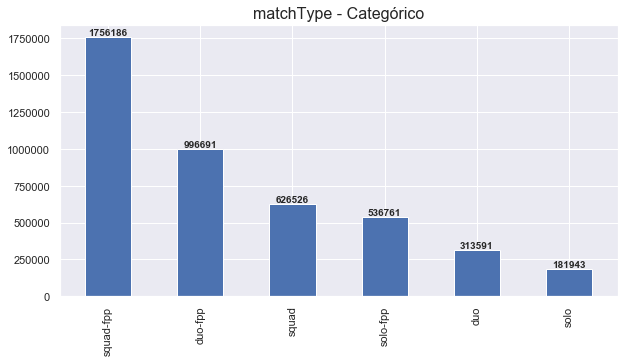

In [ ]:
#Removendo as instancias das partidas customizadas do dataframe
df = df.filter('matchType!="Customizados"')

#Criando figure para plot e definindo titulo
fig = plt.figure(figsize=(10,5));
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=3,rowspan=3)
ax1.set_title('%s - Categórico' % col,fontsize = 16)
      
#Contando os valores de cada categoria
data = df.groupBy(col).count().fillna('SemValores').toPandas().sort_values(by='count', ascending=False)
labels = np.array(data[col])
vals = np.array(data['count'])
            
#Inserindo marcações do eixo X com rotação 
bars = ax1.bar(labels,vals,0.5, align='center')
plt.xticks(rotation=90)
            
#Inserindo texto da contagem em cada barra do gráfico
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom',fontweight='bold')

### Distribuição dos atributos numéricos por tipo de partida para os dados com partidas Customizadas Expurgadas

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


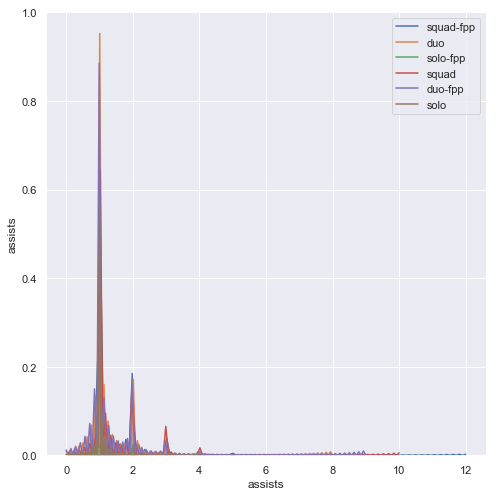

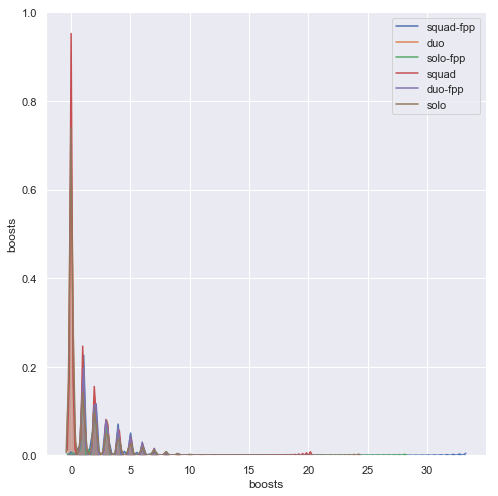

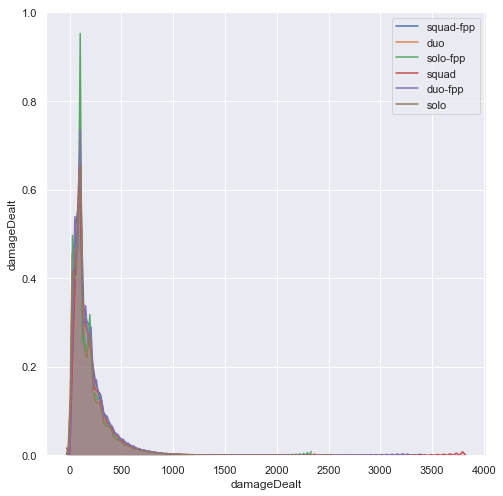

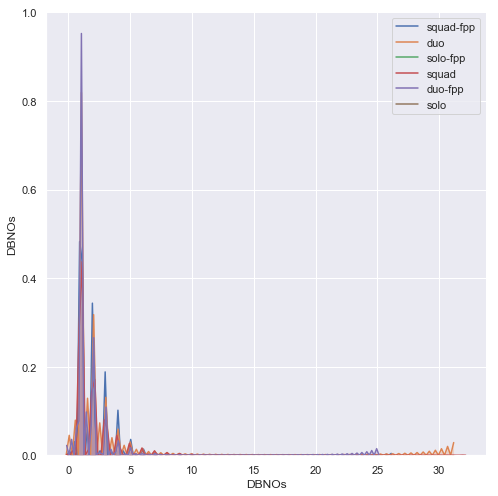

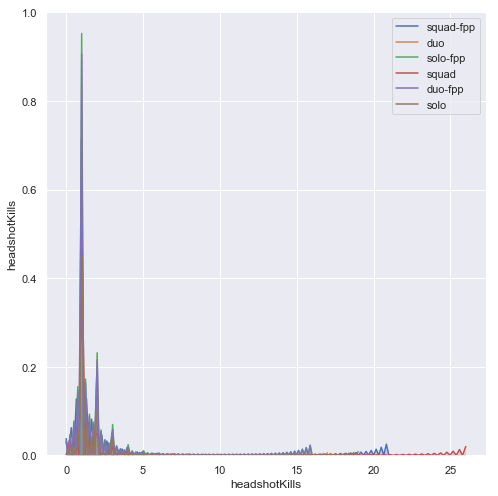

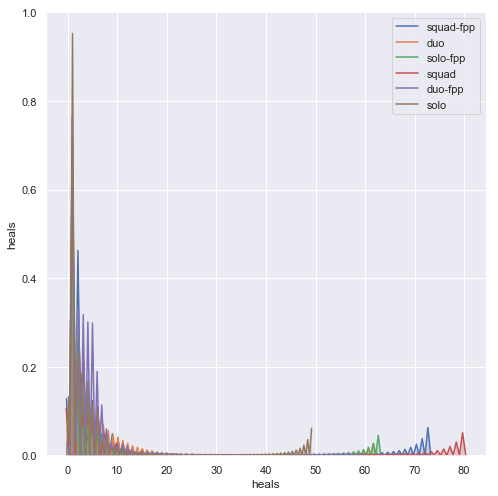

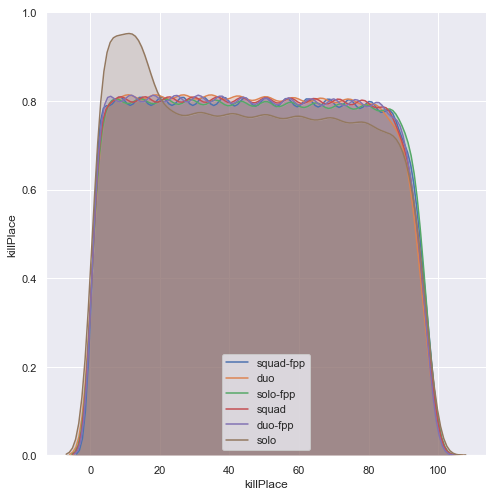

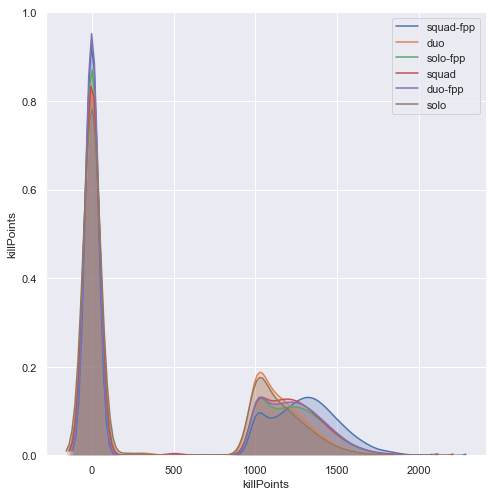

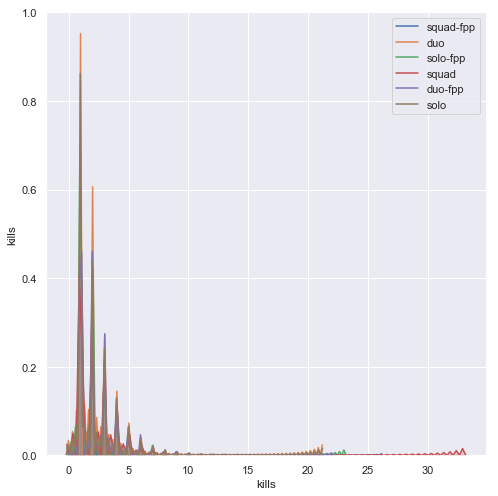

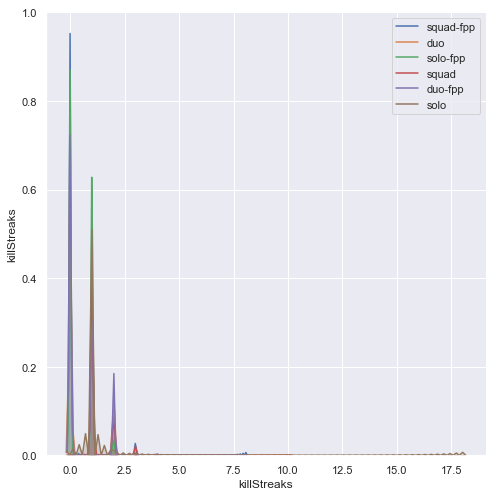

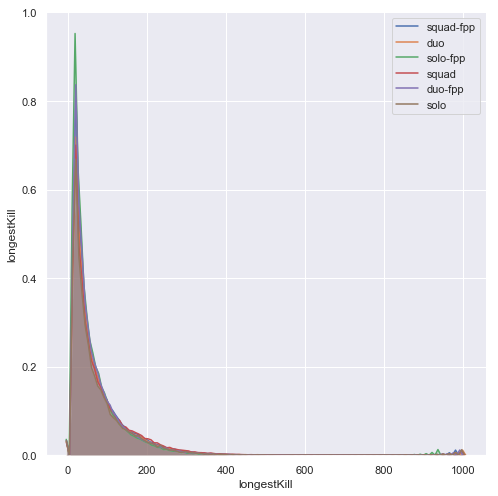

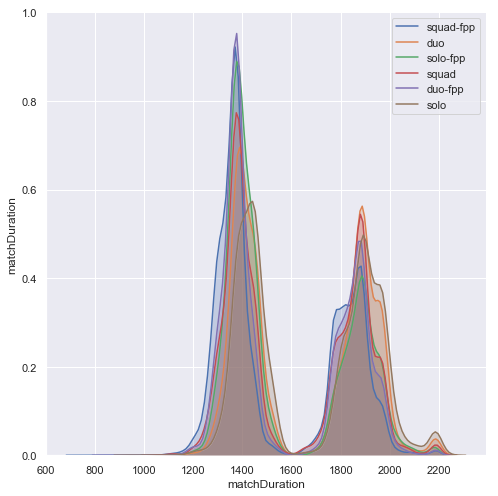

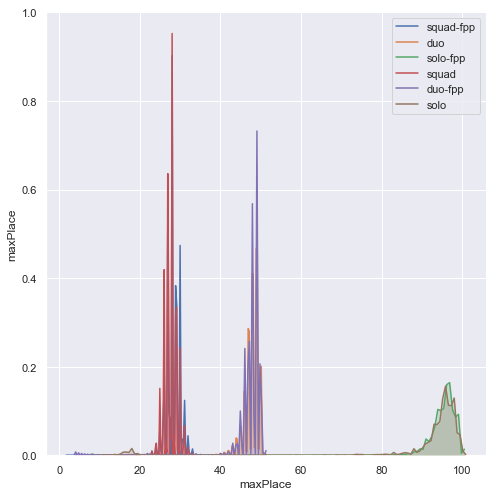

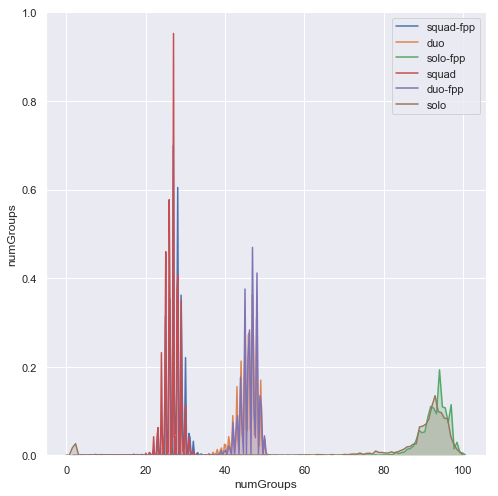

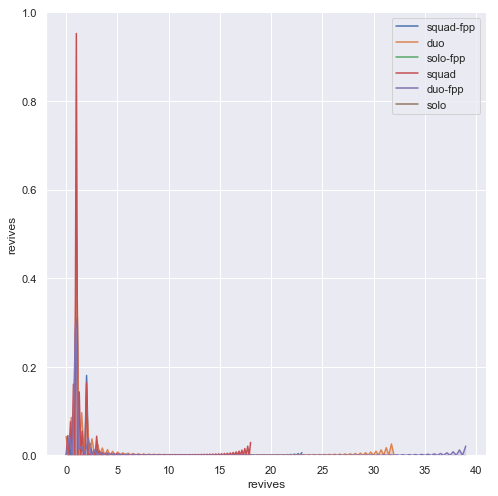

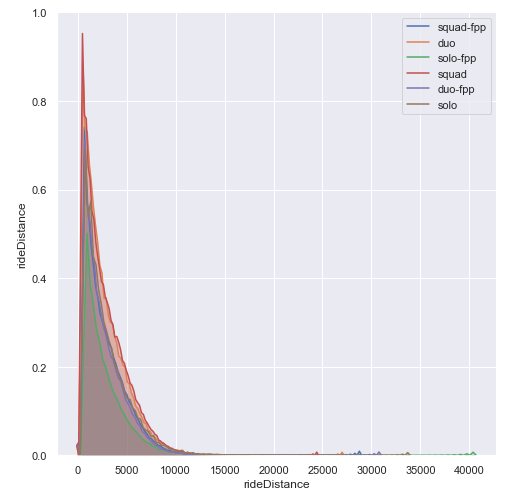

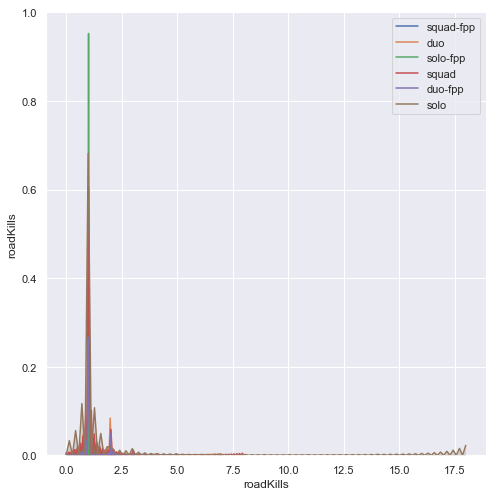

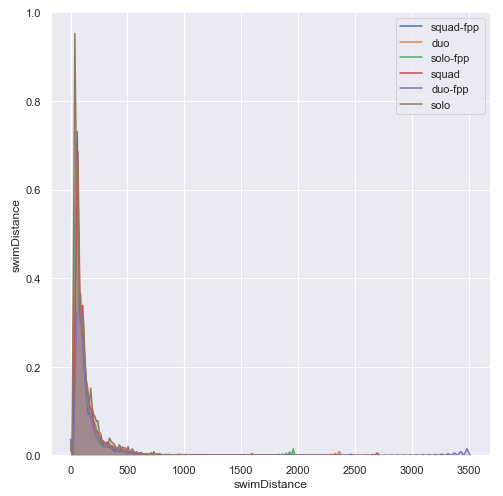

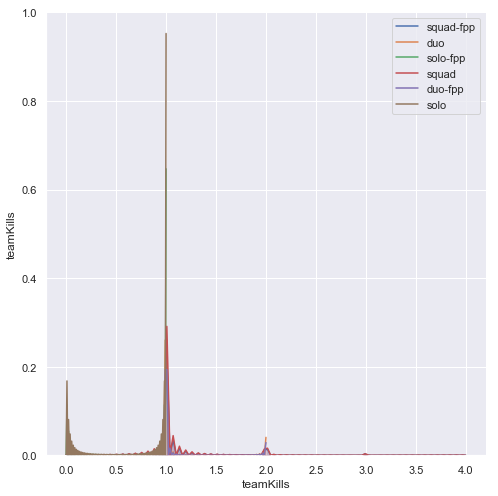

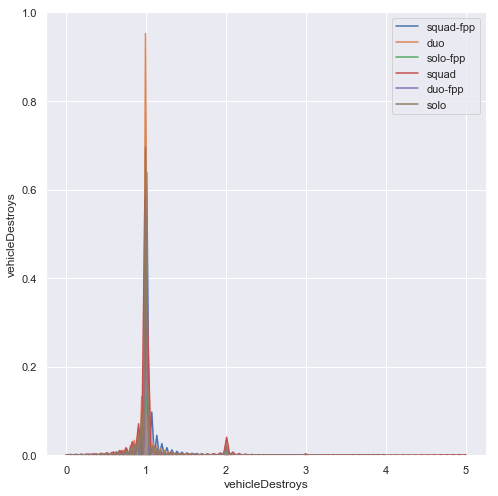

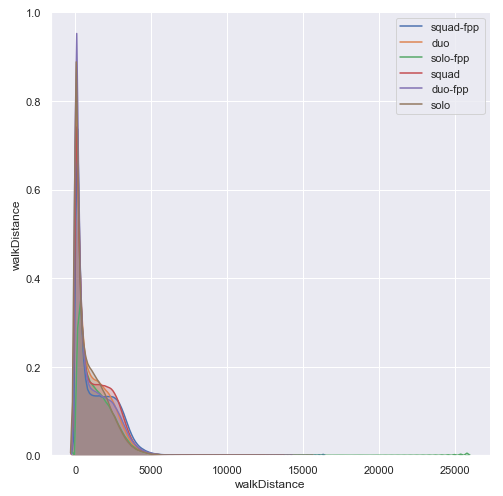

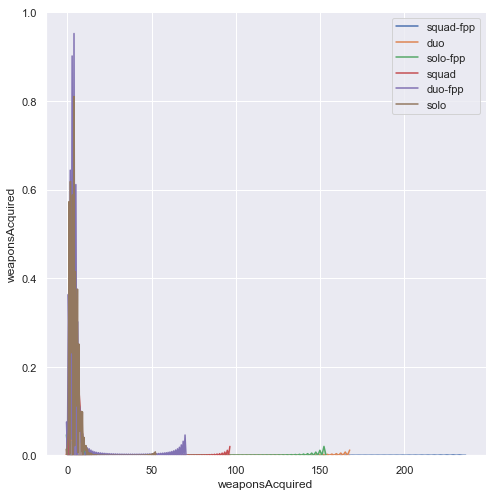

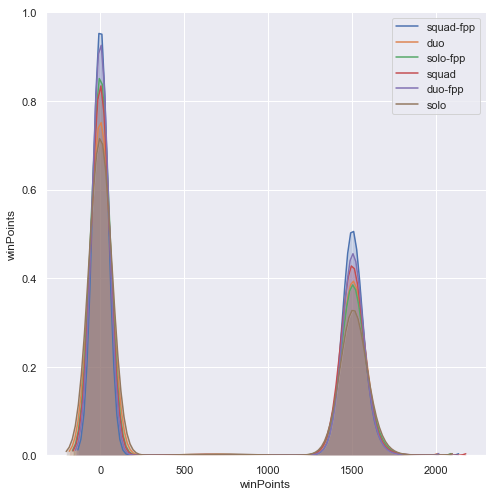

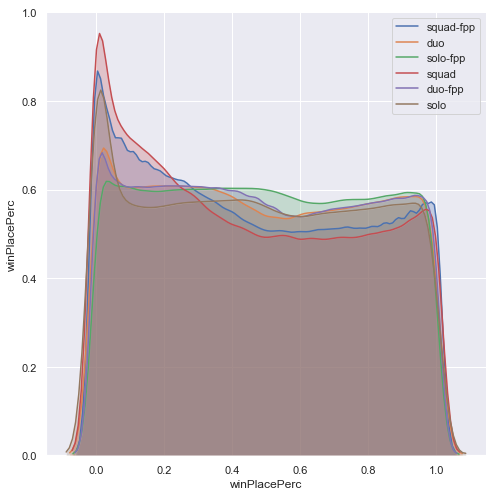

In [ ]:
#ENTRADA MANUAL: Indicar quais os atributos terão o plot segregado
#Verificando quais são as variáveis numéricas
inputCols = []
for col in df.columns:
    #Verificando tipo de dado do atributo
    if((str(df.schema[col].dataType)=='IntegerType') | (str(df.schema[col].dataType)=='DoubleType') | (str(df.schema[col].dataType)=='FloatType')):
        inputCols.append(col)
        
#ENTRADA MANUAL: Indicar qual atributo categórico será utilziado para segregar os gráficos
col = 'matchType'

#Transformando em Pandas DF para plots pelo Seaborn
df_plots = df.toPandas()

#Loop para executar os plots para todas as variáveis definidas em varplot
for i in inputCols:
    #Como o tipo de variável esperada pelo pairplot é DataFrame, convertemos cada coluna para DataFrame
    dfaux = pd.DataFrame(df_plots[[i,'matchType']])
    g = sns.pairplot(dfaux, hue="matchType",height=7)
    #Removendo a legenda do pair plot
    g._legend.remove()
    #Inserindo legenda do matplotlib
    plt.legend()

Com o expurgo das instâncias de partidas customizadas, apesar de ainda existerem outliers, estes represetam o comportamento real do objeto de avaliação.

Portanto, para o treianamento do estimador, não será adotado o tratamento de outliers, mas sim, utilizaremos o dataframe que possui somente instâncias de partidas padronizadas. Importante ressaltar que as instancias que foram desconsideradas representam um percentual pequeno em relação ao conjunto de dados inicial.

### Verificando consistencia dos grupos

In [ ]:
df_aux = df.select('*').groupBy('groupId').count()
df_aux.orderBy('count', ascending=False).show()

+--------------+-----+
|       groupId|count|
+--------------+-----+
|14d6b54cdec6bc|   74|
|b8275198faa03b|   72|
|128b07271aa012|   64|
|7385e5fe214021|   49|
|e52a2e6ca30474|   36|
|a3bc33847d2304|   31|
|6cf057e17002ff|   28|
|e8d2b3018f9d69|   28|
|566ed94d7d1fd2|   27|
|cc0f7324bf3b34|   27|
|59b747efaf412d|   26|
|eda174acfb503b|   26|
|6a292d4d1a0207|   26|
|3f20b49669a981|   26|
|ce8c1468dafa0a|   26|
|872e2b63dedcd9|   25|
|475538899822a6|   25|
|af8923aa727499|   24|
|72145e7a9939f5|   24|
|be589a52d14364|   24|
+--------------+-----+
only showing top 20 rows



Pelo regulamento do jogo, as partidas do tipo "duo" possuem no máximo de 2 pessoas, enquanto que as partidas do tipo "squad" possuem no máximo 4 pessoas.
Porém no Dataset encontramos diversos grupos com mais de 2 ou 4 jogadores por partida. 

A seguinte informação foi encontrada em um dos foruns de discussão do Kaggle referente a esta competição:

"I do want to get ahead of one inevitable question. You will notice that there are frequently more than the supposed max number of players in a group regardless of mode. For example, you might have more than 4 people in a group with matchType == 'squad'. This is caused by disconnections in the game. When disconnections occur, players of multiple groups are stored in the API's database as having the same final placement. This has the consequence that when I make the groupId feature from final placements, we have too large of groups. Please take groupId to mean "players that have the same final placement" and not "players that definitely played in a group together.""

https://www.kaggle.com/c/pubg-finish-placement-prediction/discussion/68965#406275

Apesar do modelo não levar em consideração o groupID, tendo em vista que são valores únicos por partida, é um elemento que mostra inconsistencia na coleta de dados pela API do jogo.

### Verificando distribuição dos atributos entre ganhadores e perdedores

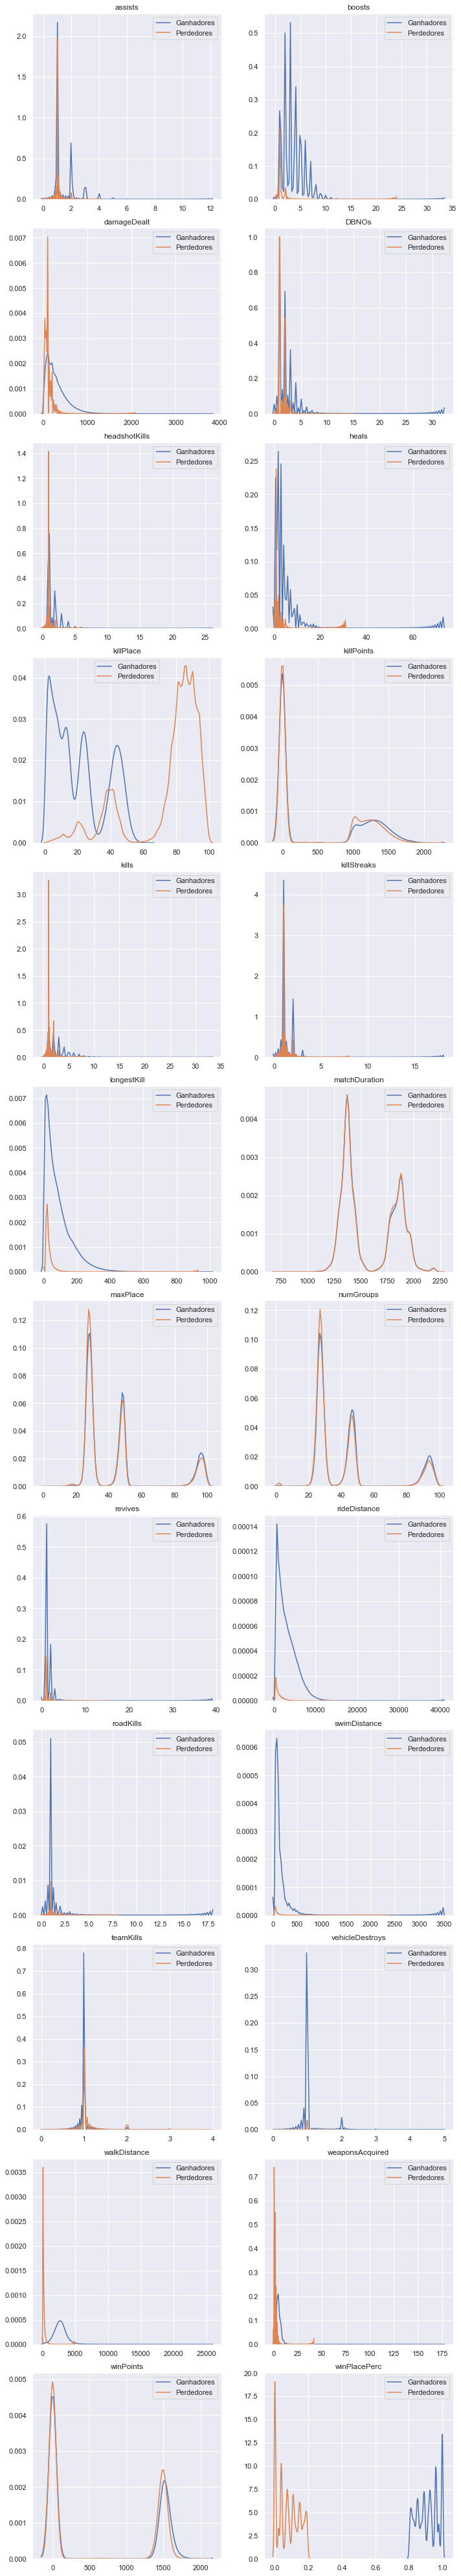

In [ ]:
#Verificando quais são as variáveis numéricas
inputCols = []
for col in df.columns:
    #Verificando tipo de dado do atributo
    if((str(df.schema[col].dataType)=='IntegerType') | (str(df.schema[col].dataType)=='DoubleType') | (str(df.schema[col].dataType)=='FloatType')):
        inputCols.append(col)
        
#Criando DF em pandas para os plots
dfaux = df.toPandas()

#Criando figure para plot e definindo titulo        
fig = plt.figure(figsize=(10,5*len(inputCols)));

i = 0
j = 0
for col in inputCols:
    #Plotando gráfico heatmap de correlação Pearson
    ax1 = plt.subplot2grid((len(inputCols), 2), (i, j), colspan=1, rowspan=1)
    sns.kdeplot(dfaux.loc[dfaux['winPlacePerc'] > 0.8, col] , label = 'Ganhadores')
    sns.kdeplot(dfaux.loc[dfaux['winPlacePerc'] < 0.2, col] , label = 'Perdedores')
    ax1.set_title(col)
    
    #Incrementando as variáveis auxiliares para posicionamento dos plots
    if j==1:
        j=0
        i = i+1
    else:
        j = j+1
        
#Ajustando as bordas dos gráficos
fig.tight_layout(rect=[0, 0.03, 1, 0.95])   

Por um lado, avaliando o gráfico, é notável que há atributos que mudam significativamente sua distribuição para Ganhadores e Perdedores. Isso é uma indicação preliminar que estes são atributos que descrevem bem o target.

Por outro lado, há variaveis que não tem a distribuição afetada pela dinstinção de Ganhadores ou Perdedores, como por exemplo matchDuration, winPoints, teamKills, numGroup, maxPlace.

### Avaliando Graficamente correlação entre atributos numéricos e Target

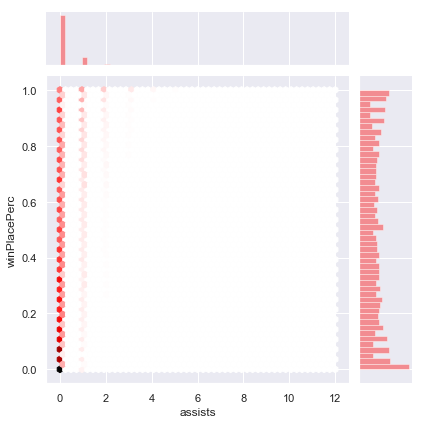

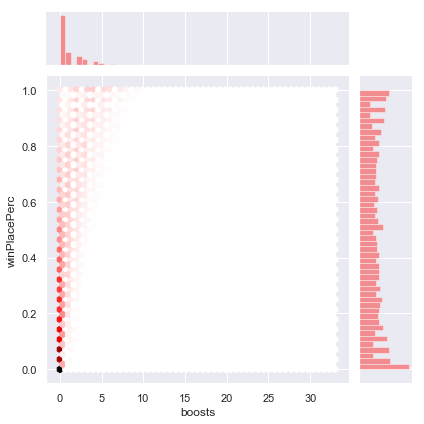

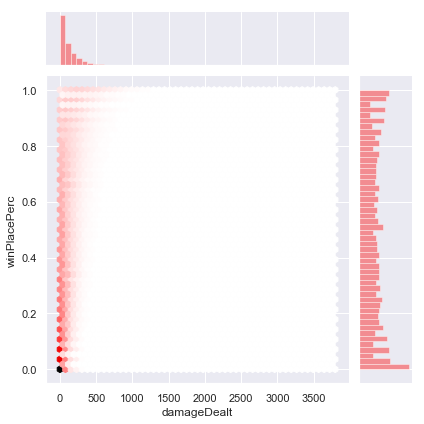

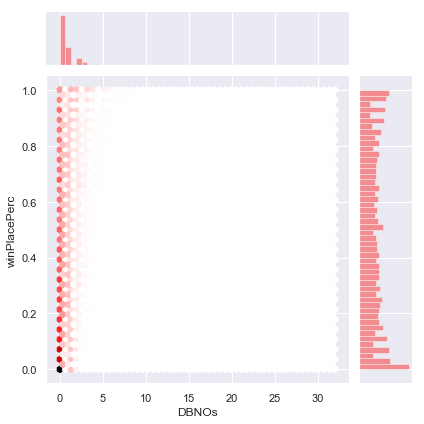

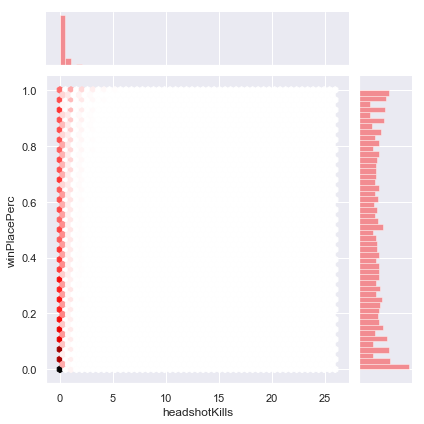

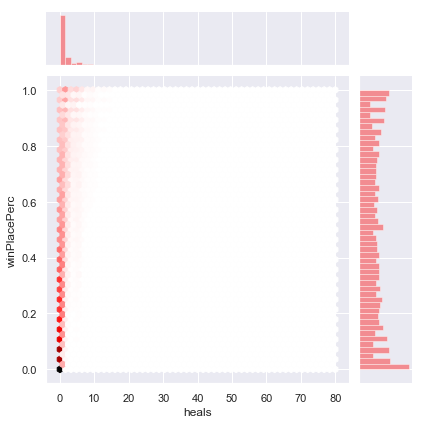

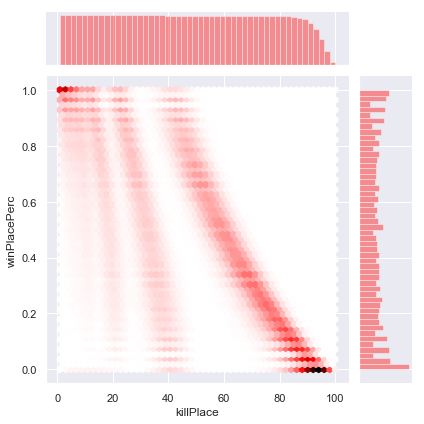

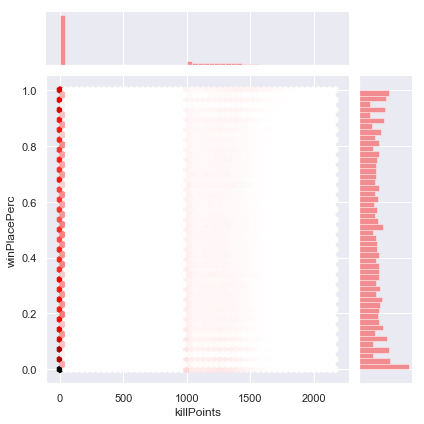

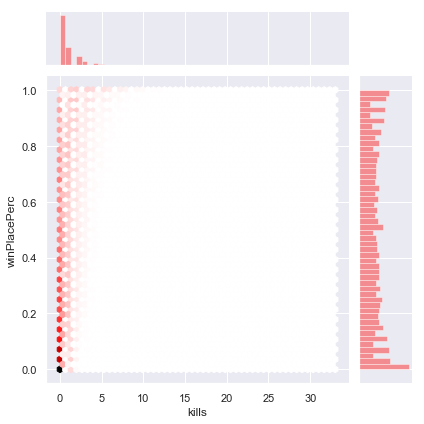

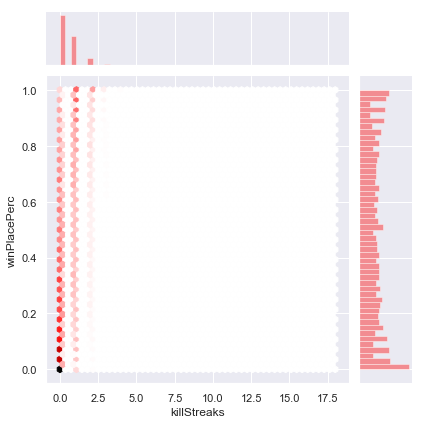

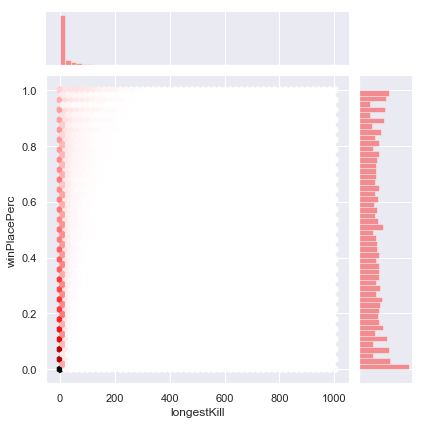

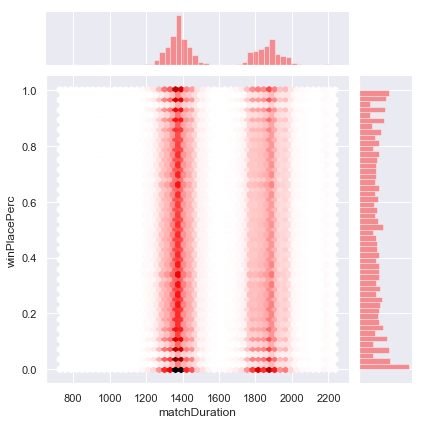

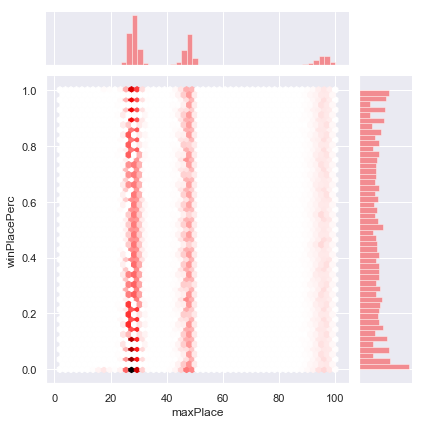

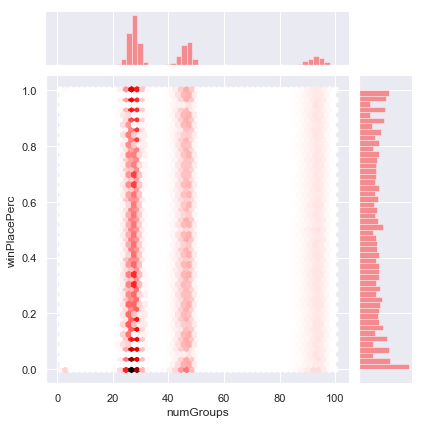

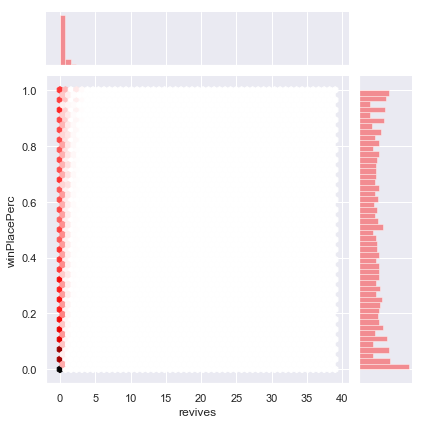

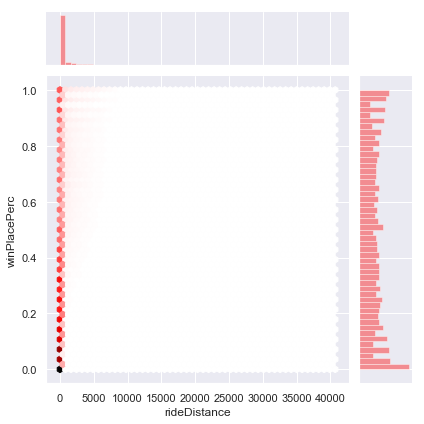

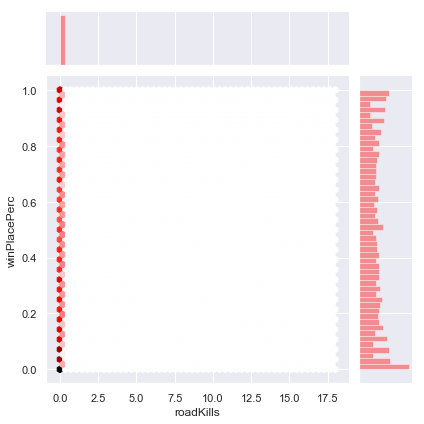

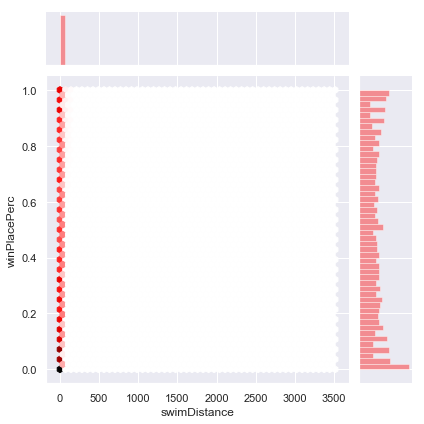

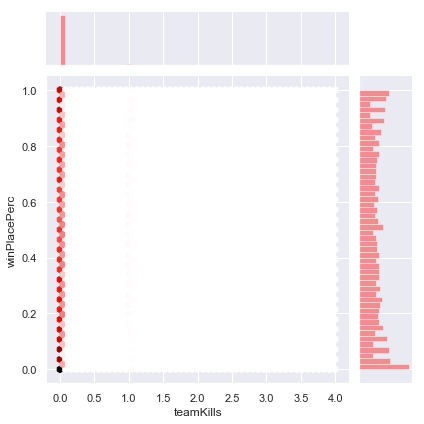

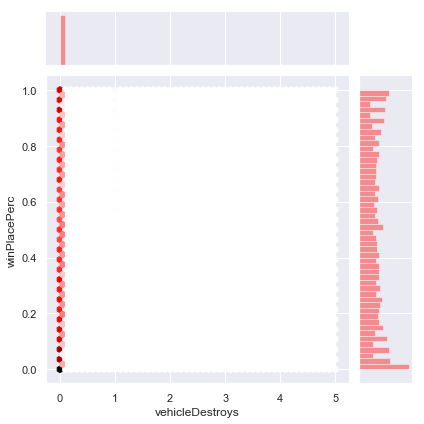

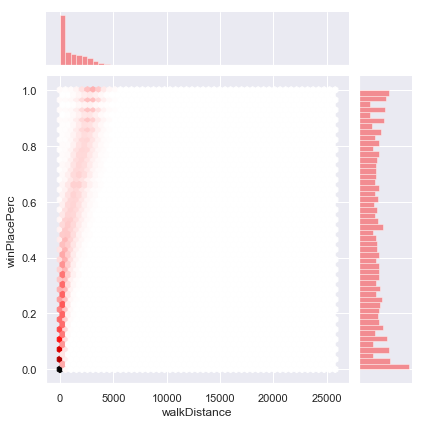

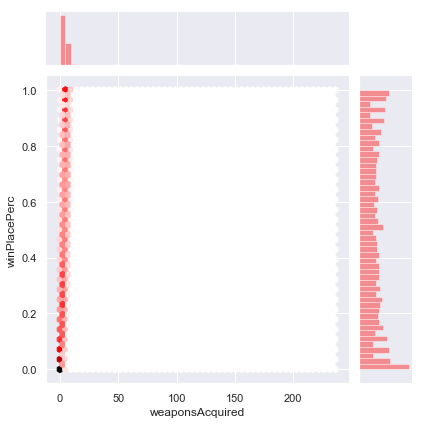

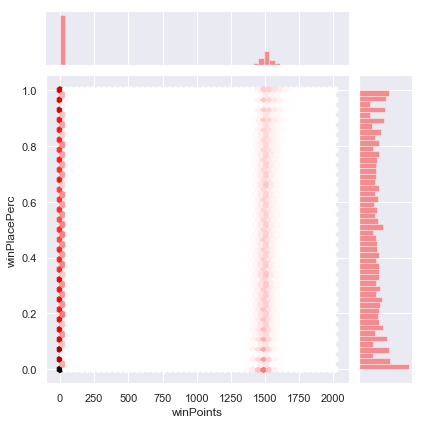

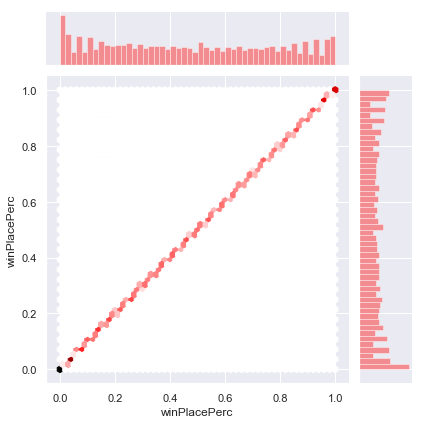

In [ ]:
#Transformando em Pandas DF para plots pelo Seaborn
df_plots = df.toPandas()

#Plotando os gráficos para verifica a correlação entre os atributos e o target
for i in inputCols:   
    g = sns.jointplot(df_plots[i],df_plots['winPlacePerc'], kind="hex", color="red")

Pela a avaliação gráfica, é visualmente claro que há algumas variáveis que possuem certa correlação com o target e outras não, a ser confirmado pelo calculos das correlações nos próximos passos.

###  Matriz de Correlação

In [ ]:
#-------------------- CORRELAÇÕES PARA OS DADOS COM INSTANCIAS CUSTOMIZADAS EXPURGADAS ------------------------#

#Verificando quais são as variáveis numéricas
inputCols = []
for col in df.columns:
    #Verificando tipo de dado do atributo
    if((str(df.schema[col].dataType)=='IntegerType') | (str(df.schema[col].dataType)=='DoubleType') | (str(df.schema[col].dataType)=='FloatType')):
        inputCols.append(col)
        
#Mapeando os RDD's para calculos de correlação
features = df.select(*inputCols).rdd.map(lambda row: row[0:])

#Calculo dos valores de correlações método Pearson
corr_mat=Statistics.corr(features, method="pearson")
corr_pearson = pd.DataFrame(corr_mat)
corr_pearson.index, corr_pearson.columns = inputCols, inputCols

#Calculo dos valores de correlações método Spearman
corr_mat=Statistics.corr(features, method="spearman")
corr_spear = pd.DataFrame(corr_mat)
corr_spear.index, corr_spear.columns = inputCols, inputCols

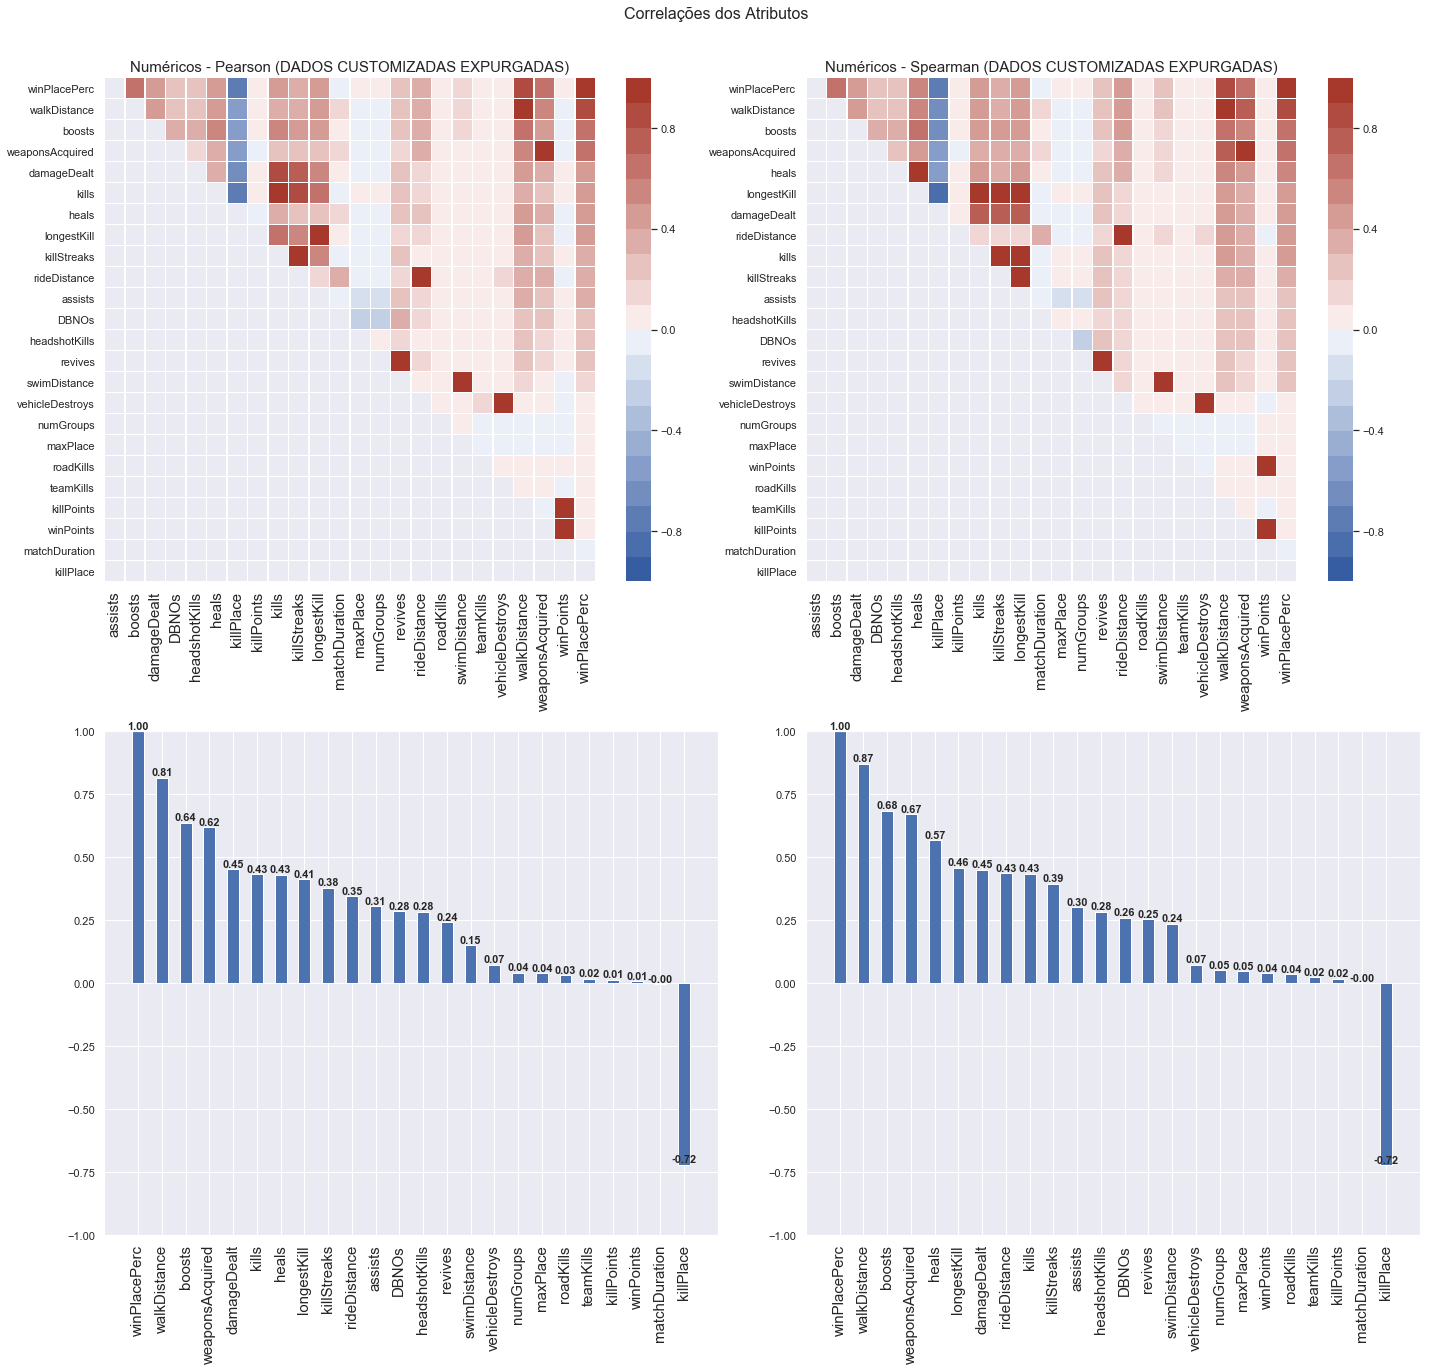

In [ ]:
#Criando figure para plot e definindo titulo
fig = plt.figure(figsize=(20,20));
fig.suptitle('Correlações dos Atributos', fontsize=16)

#Definindo estilo de cores para o correlograma
colormap= sns.diverging_palette(255, 15, l=40, n=20, center="light")

#Criando mascara para legendas
mask = np.zeros_like(corr_pearson, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

#Plotando gráfico heatmap de correlação Pearson
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
ax1.set_title('Numéricos - Pearson (DADOS CUSTOMIZADAS EXPURGADAS)', fontsize=15)
sns.heatmap(corr_pearson, vmin=-1, vmax=1, mask=mask, cmap=colormap,linewidths=.5)
plt.yticks(rotation=0)
plt.xticks(fontsize=15)

#Plotando gráfico de pareto das correlações Pearson
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1,rowspan=1)
corr_pearson = corr_pearson.sort_values(by='winPlacePerc',ascending=False)
bars = ax2.bar(corr_pearson.index,corr_pearson['winPlacePerc'],0.5, align='center')
plt.xticks(rotation=90,fontsize=15)
plt.ylim(-1,1)

#Inserindo texto da contagem em cada barra do gráfico
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, f'{height:.2f}', ha='center', va='bottom',fontweight='bold', fontsize=11)

#Plotando gráfico heatmap de correlação Spearman
ax3 = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
ax3.set_title('Numéricos - Spearman (DADOS CUSTOMIZADAS EXPURGADAS)', fontsize=15)
sns.heatmap(corr_spear, vmin=-1, vmax=1, mask=mask, cmap=colormap,linewidths=.5)
plt.yticks(rotation=0)
plt.xticks(fontsize=15)

#Plotando gráfico de pareto das correlações Spearman
ax4 = plt.subplot2grid((2, 2), (1, 1), colspan=1,rowspan=1)
corr_spear = corr_spear.sort_values(by='winPlacePerc',ascending=False)
bars = ax4.bar(corr_spear.index,corr_spear['winPlacePerc'],0.5, align='center')
plt.xticks(rotation=90,fontsize=15)
plt.ylim(-1,1)

#Inserindo texto da contagem em cada barra do gráfico
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, f'{height:.2f}', ha='center', va='bottom',fontweight='bold', fontsize=11)

#Ajustando as bordas do gráfico
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

#Liberando memória
#colormap = None
#mask = None
#inputCols = None
#features = None
#corr_pearson = None
#corr_spear = None
#corr_mat = None
#gc.collect()

Os valores de correlações encontrados para os dados tratados em relação ao Target, confirmam as observações feitas graficamente pelas distribuções e correlogramas.

### Normalização dos dados
Esta função normaliza os atributos cujo o tipo é numérico e mantem os atributos categóricos no dataframe. A escolha do método utilizado para normalização depende do comportamento dos dados. ESSE ALGORITMO NAO RODA SE HOUVER DADO AUSENTE NO DATAFRAME.

In [ ]:
#ENTRADA MANUAL: Selecione o tipo de normalizaçao: 1:StandardScaler||2:MinMaxScaler||3:MaxAbsScaler
tiponorm = 1

#ENTRADA MANUAL: Selecione o TARGET para remover da normalização
target = 'winPlacePerc'

#Atribuindo outro DF para o dado tratado com outlier e normalizacao
df_Tratado = df

#Verificando quais são as variáveis numéricas
inputCols = []
for col in df_Tratado.columns:
    #Verificando tipo de dado do atributo
    if((str(df_Tratado.schema[col].dataType)=='IntegerType') | (str(df_Tratado.schema[col].dataType)=='DoubleType') | (str(df_Tratado.schema[col].dataType)=='FloatType')):
        inputCols.append(col)
        
#Removendo os valores do target da normalização
inputCols.remove(target)

#Selecionando os atributos para a normalizacao e passando para o vector assembler
assembler = VectorAssembler(inputCols=inputCols, outputCol = 'features')

#Ajustando para o formato adequado para função de normalização
dadosNormalizados = assembler.transform(df_Tratado).select('features')

#Definindo o método do scaler
if tiponorm == 1:
    scaler = StandardScaler(inputCol='features', outputCol="scaledFeatures", withStd=True, withMean=True)
elif tiponorm == 2:
    scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
elif tiponorm == 3:
    scaler = MaxAbsScaler(inputCol="features", outputCol="scaledFeatures")

#Aplicando normalização
scalerModel = scaler.fit(dadosNormalizados)
dadosNormalizados = scalerModel.transform(dadosNormalizados)

#Retornando dados normalizados para formato de data frame para análises e join com o dataframe com os atributos categoricos
dadosNormalizados = dadosNormalizados.select("scaledFeatures")
dadosNormalizados = dadosNormalizados.rdd.map(lambda x:[float(y) for y in x['scaledFeatures']]).toDF(list(inputCols))

#Criando um ID para cada dataframe
dadosNormalizados=dadosNormalizados.withColumn('row_index', F.monotonically_increasing_id())
df_Tratado=df_Tratado.withColumn('row_index', F.monotonically_increasing_id())

#Dropando as colunas com danos sem normalização
df_Tratado = df_Tratado.drop(*inputCols)

#Incluindo os atributos normalizados no dataframe
df_Tratado = df_Tratado.join(dadosNormalizados, on=["row_index"], how='outer').sort("row_index").drop("row_index")

#Alocando na memória para próximas etapas
df_Tratado.persist()

DataFrame[Id: string, groupId: string, matchId: string, matchType: string, winPlacePerc: double, assists: double, boosts: double, damageDealt: double, DBNOs: double, headshotKills: double, heals: double, killPlace: double, killPoints: double, kills: double, killStreaks: double, longestKill: double, matchDuration: double, maxPlace: double, numGroups: double, revives: double, rideDistance: double, roadKills: double, swimDistance: double, teamKills: double, vehicleDestroys: double, walkDistance: double, weaponsAcquired: double, winPoints: double]

### Principal Component Analysis (PCA)
O PCA é um método utilizado para verificar se pode haver redução de dimensões (atributos). O metodo utiliza medidas de distancia entre as variáveis, sendo assim, é fundamental realizar a centralização e normalização dos atributos antes de aplicar essa técnica.

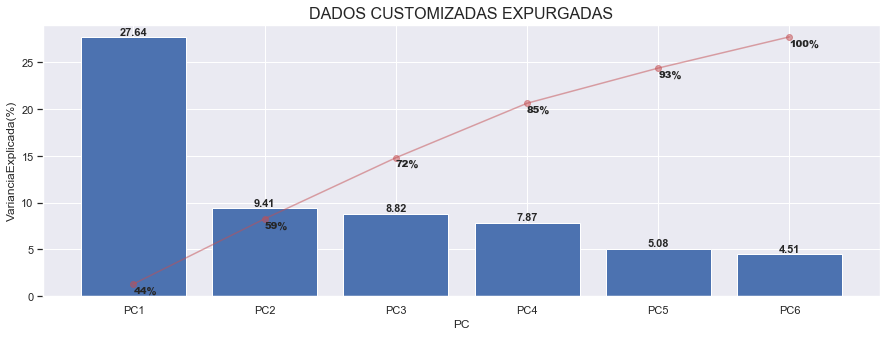

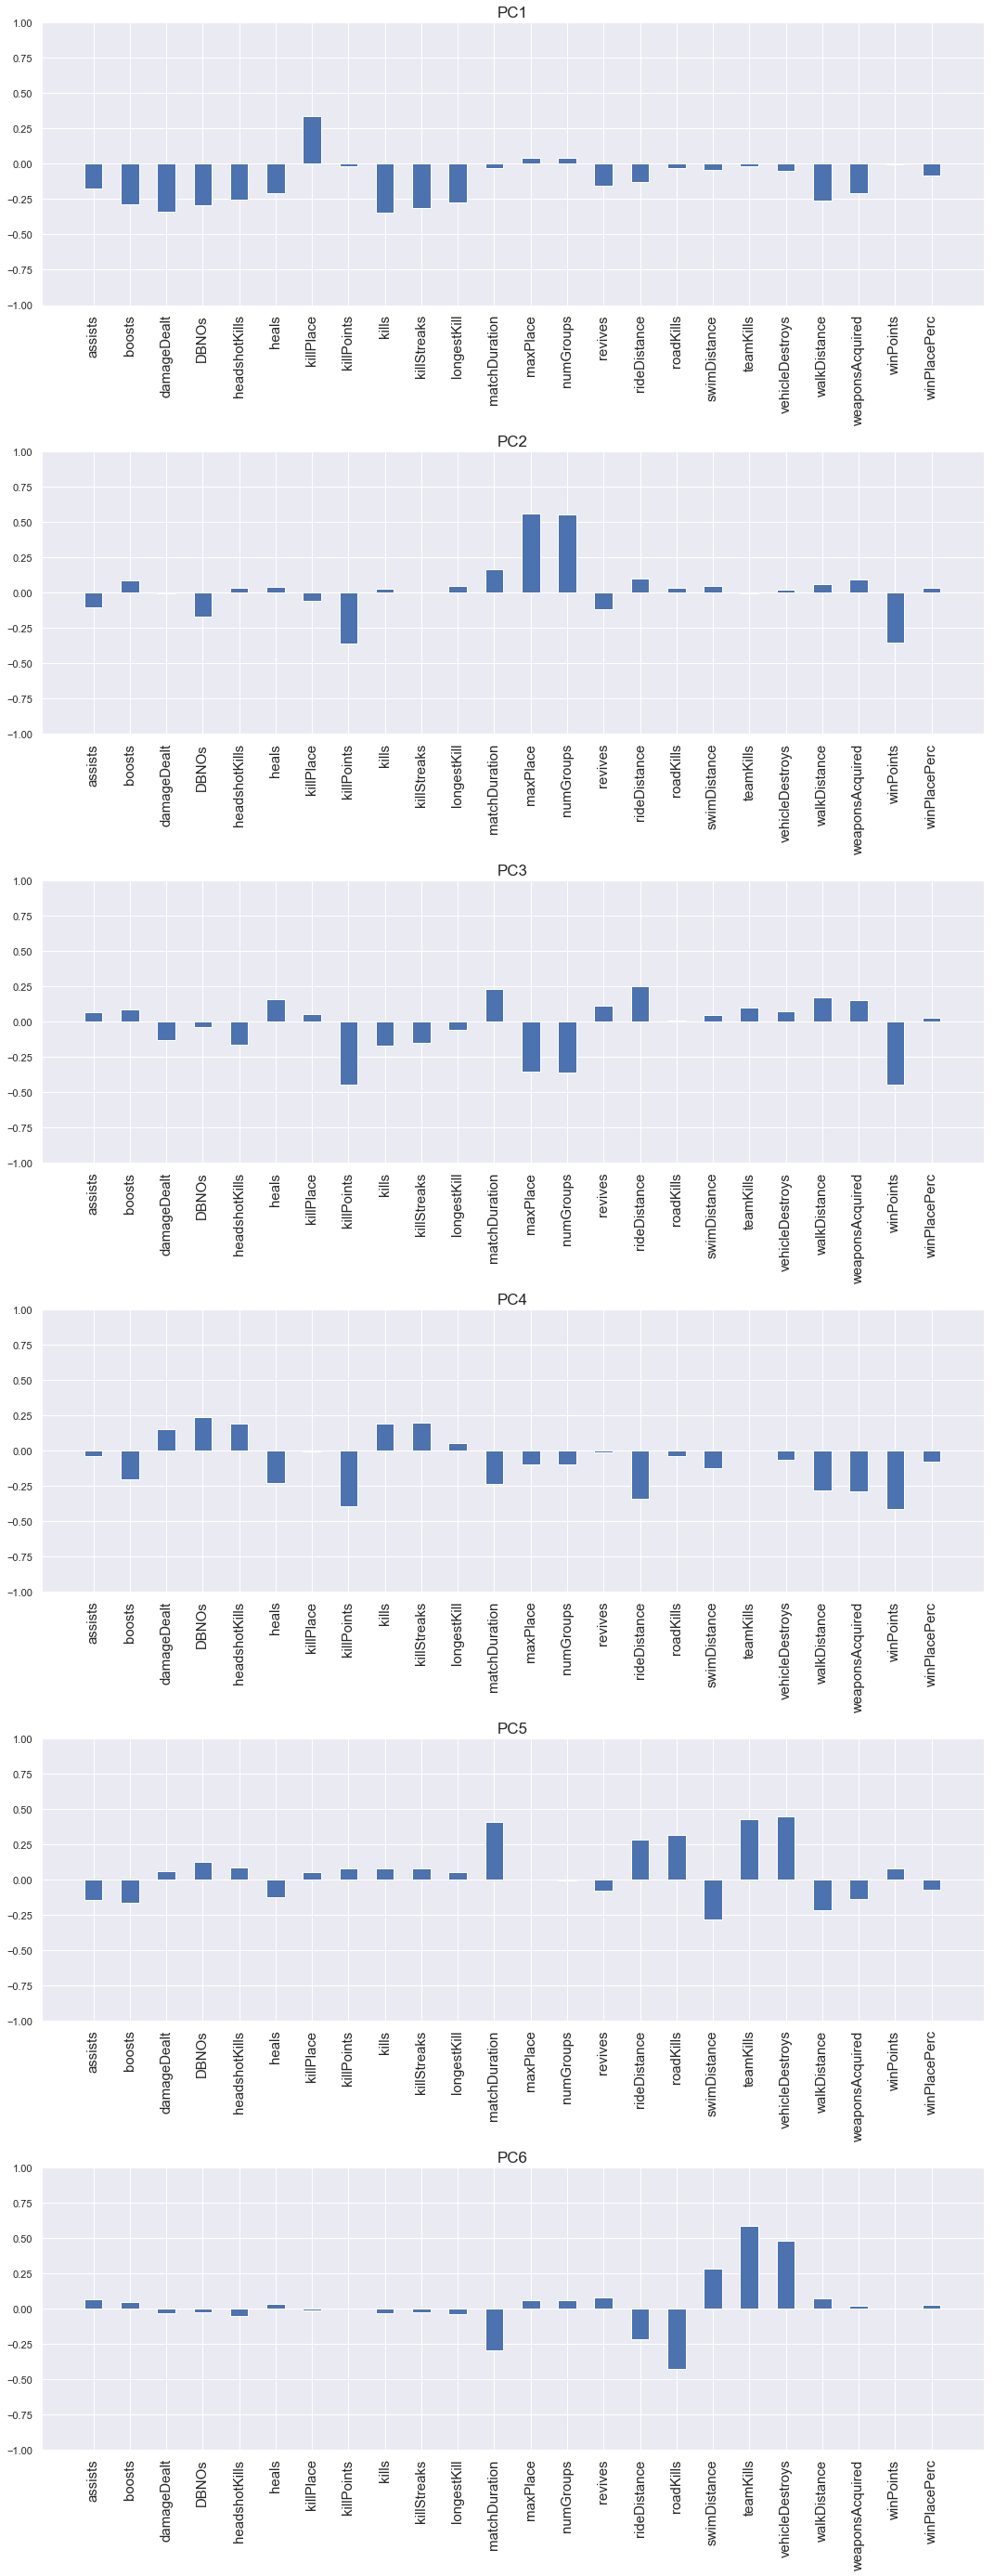

In [ ]:
#ENTRADA MANUAL: Definir o k do PCA
k=6

# ------------------ EXECUTANDO PCA ----------------------#
#Verificando quais são as variáveis numéricas
inputCols = []
for col in df.columns:
    #Verificando tipo de dado do atributo
    if((str(df.schema[col].dataType)=='IntegerType') | (str(df.schema[col].dataType)=='DoubleType') | (str(df.schema[col].dataType)=='FloatType')):
        inputCols.append(col)

#Selecionando os atributos para o PCA
assembler = VectorAssembler(inputCols=inputCols, outputCol = 'features')

#Ajustando para o formato adequado para função PCA p
dadosPCA = assembler.transform(df_Tratado).select('features')

#Executando PCA para o df sem tratamento de dados
pca = PCA(k=k, inputCol = 'features', outputCol="pcaFeatures")
modeloPCA = pca.fit(dadosPCA)

#Gerando dataFrame das variancias explicadas 
varExplicada = pd.DataFrame ({'VarianciaExplicada(%)':np.round(modeloPCA.explainedVariance * 100,2), 
                    'PC':['PC' + str(i) for i in range(1,PCA.getK(modeloPCA)+1)]})

# ------------------ PLOT PARETO  ----------------------#
#Criando Figure para os plots
fig = plt.figure(figsize=(10,5));

#Selecionando dados para Plot da variancia explicada para os PC's
df_aux = varExplicada.sort_values('VarianciaExplicada(%)', ascending=False)
x = df_aux['PC'].values
y = df_aux['VarianciaExplicada(%)'].values
weights = y / y.sum()
cumsum = weights.cumsum()

#Plot da variancia explicada para os PC's
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1,rowspan=1)    
bars = ax1.bar(x, y)
ax1.set_title('DADOS CUSTOMIZADAS EXPURGADAS',fontsize = 16)
ax1.set_xlabel('PC')
ax1.set_ylabel('VarianciaExplicada(%)')

#Inserindo texto da contagem em cada barra do gráfico
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, f'{height:.2f}', ha='center', va='bottom',fontweight='bold', fontsize=11)

#Plotando linha cumulativa
ax2 = ax1.twinx()
ax2.plot(x, cumsum, '-ro', alpha=0.5)
ax2.set_ylabel('', color='r')
ax2.tick_params('y', colors='r')
ax2.set_yticks([])
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

#Inserindo valores da linha cumulativa
formatted_weights = ['{0:.0%}'.format(x) for x in cumsum]
for i, txt in enumerate(formatted_weights):
    ax2.annotate(txt, (x[i], (cumsum[i]-0.02)), fontweight='heavy')


# ------------------ PLOT GRAFICO BARRAS DA CONTRIBUICAO DE CADA ATRIBUTO PARA CADA PC ----------------------#
#Gerando dataframe do informaçao de contribuicao de cada atributo nos PC's
pcs = np.round(modeloPCA.pc.toArray(),3)
df_pc = pd.DataFrame(pcs, columns = ['PC'+str(i) for i in range(1, PCA.getK(modeloPCA)+1)], index = inputCols)

#Criando figure para plot e definindo título de acordo com quatidade de PC's do PCA
fig = plt.figure(figsize=(15,7*len(df_pc.columns)));

#Definindo quantidade de linhas do plot e inicializando variável auxiliar
linhas = len(df_pc.columns)
i=0

#Loop para plotar os gráficos das PC's
for col in df_pc.columns:
    #Plot das PC's
    ax1 = plt.subplot2grid((linhas, 1), (i, 0), colspan=1,rowspan=1)
    ax1.set_title(col, fontsize=17)
    bars = ax1.bar(df_pc.index,df_pc[col],0.5, align='center')
    plt.xticks(rotation=90,fontsize=15)
    plt.ylim(-1,1)
    i=i+1

#Ajustando as bordas do gráfico
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Model Pipeline

In [ ]:
df_Tratado.printSchema()

root
 |-- Id: string (nullable = true)
 |-- groupId: string (nullable = true)
 |-- matchId: string (nullable = true)
 |-- matchType: string (nullable = true)
 |-- assists: double (nullable = true)
 |-- boosts: double (nullable = true)
 |-- damageDealt: double (nullable = true)
 |-- DBNOs: double (nullable = true)
 |-- headshotKills: double (nullable = true)
 |-- heals: double (nullable = true)
 |-- killPlace: double (nullable = true)
 |-- killPoints: double (nullable = true)
 |-- kills: double (nullable = true)
 |-- killStreaks: double (nullable = true)
 |-- longestKill: double (nullable = true)
 |-- matchDuration: double (nullable = true)
 |-- maxPlace: double (nullable = true)
 |-- numGroups: double (nullable = true)
 |-- rankPoints: double (nullable = true)
 |-- revives: double (nullable = true)
 |-- rideDistance: double (nullable = true)
 |-- roadKills: double (nullable = true)
 |-- swimDistance: double (nullable = true)
 |-- teamKills: double (nullable = true)
 |-- vehicleDestroys

### Selecionando os atributos para os estimadores




Com base nas avaliações anteriores do correlograma, distribuições relacionadas ao target, e índices de correlação de pearson e spearman, os seguintes atributos serão incluídos no estimador:

In [ ]:
#ENTRADA MANUAL: Inserir no vetor quais atributos serão utilizador para os estimadores
inputCols =['assists',
            'boosts',
            'damageDealt',
            #'DBNOs',
            'headshotKills',
            'heals',
            'killPlace',
            #'killPoints',
            'kills',
            'killStreaks',
            'longestKill',
            #'matchDuration',
            #'maxPlace',
            #'numGroups',
            #'rankPoints',
            'revives',
            #'rideDistance',
            #'roadKills',
            #'swimDistance',
            #'teamKills',
            #'vehicleDestroys',
            'walkDistance',
            'weaponsAcquired',
            #'winPoints' \
            ]

#ENTRADA MANUAL: Inserir qual é o TARGET
Target = 'winPlacePerc'

#Gerando vetor das entradas e do target no formato de entrada para os estimadores
vectorAssembler = VectorAssembler(inputCols =inputCols , outputCol = 'features')
dadosEstimador = vectorAssembler.transform(df_Tratado)
dadosEstimador = dadosEstimador.select(['features', Target])

#Separando os dados entre dados de treinamento e validação
splits = dadosEstimador.randomSplit([0.7, 0.3],seed=0)
train_df = splits[0]
test_df = splits[1]

### Aplicando Regressão linear com GridSearch

In [ ]:
# ------------------------------ REGRESSÃO LINEAR COM GRIDSEACH---------------------------#

#Definindo o estimador para Regressão Linear Generalizada
lr = LinearRegression(featuresCol = 'features', labelCol=Target, maxIter=10)

#Incluindo os elementos do pipeline para o estimador
lr_pipeline = Pipeline(stages=[lr])

#Criando a configuração de parametros para testes do pipeline
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1,0.01]) \
    .addGrid(lr.elasticNetParam, [0,0.5])\
    .build()

#Utilizando crossvalidator, podemos utilizar o Pipeline como um estimador, o paramGrid com conjuto de parametros
#para este estimador e definimos o método de validação para definir o melhor conjunto de parametros.
crosVal = CrossValidator(estimator=lr_pipeline,
                           estimatorParamMaps=lr_paramGrid,
                           evaluator=RegressionEvaluator(labelCol=Target, metricName='r2'),                           
                           numFolds=2)

#Executando o algoritmo de crossvalidação com base no elementos configurados anteriormente
lr_cvModel = crosVal.fit(train_df)

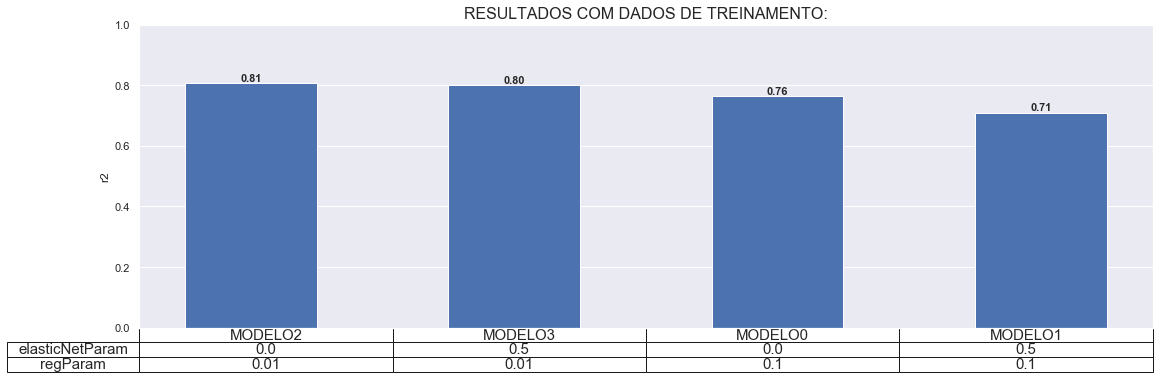

In [ ]:
# Verificando os resultados com os dados de treinamento
#Listando as combinações de parametros utilizados em cada modelo
params = [{p.name: v for p, v in m.items()} for m in lr_cvModel.getEstimatorParamMaps()]

#Listando o resultado e agrupando em um dataframe
lr_resultado = pd.DataFrame.from_dict([
    {lr_cvModel.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, lr_cvModel.avgMetrics)
])
#Ordenando o daframe dos resultados pelos resultados para plot
lr_resultado = lr_resultado.sort_values(lr_cvModel.getEvaluator().getMetricName(), ascending=False)

#Criando Figure para os plots
fig = plt.figure(figsize=(15,10));

#Plot do resultado com os dados de treinamento
ax1 = plt.subplot2grid((2, 1), (0, 0), colspan=1,rowspan=1)
xlabels = ['MODELO'+str(i) for i in lr_resultado.index]
bars = ax1.bar(xlabels,lr_resultado[lr_cvModel.getEvaluator().getMetricName()],0.5)
ax1.set_title('RESULTADOS COM DADOS DE TREINAMENTO:',fontsize = 16)
ax1.set_ylabel(lr_cvModel.getEvaluator().getMetricName())
plt.xticks([])
plt.ylim(0,1)

#Inserindo texto da contagem em cada barra do gráfico
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, f'{height:.2f}', ha='center', va='bottom',fontweight='bold', fontsize=11)

# Removendo a coluna da medida de desempenho já que vai ser desnecessária na tabela
lr_resultado = lr_resultado.drop(columns=[lr_cvModel.getEvaluator().getMetricName()])

#Plotando a tabela com os valores dos parametros
tabela_resultados = plt.table(cellText=lr_resultado.values.T,
                    rowLabels=lr_resultado.columns,
                    colLabels=xlabels,
                    cellLoc= 'center',
                    rowLoc = 'center',
                    loc='bottom')

tabela_resultados.set_fontsize(15)

#Ajustando as bordas dos gráficos
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Resultados com os dados de Teste
R2: 0.81


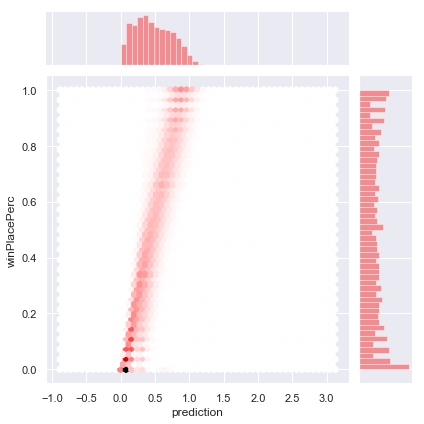

In [ ]:
#Realizando a avaliação com os dados de teste
lr_validacao = lr_cvModel.transform(test_df)
lr_avaliacao = RegressionEvaluator(predictionCol="prediction",labelCol=Target,metricName="r2")

#Apresentação dos resultados com os dados de teste
r2_test = lr_avaliacao.evaluate(lr_validacao)
print("Resultados com os dados de Teste")
print("R2:", round(r2_test,2))

#Selecionando somente as colunas dos valores preditos e observador para plot dos resultados
lr_avaliacao = lr_validacao.toPandas()
lr_avaliacao = lr_avaliacao[[Target,'prediction']]

#Plot dos valores preditos x valores observados
ax1 = sns.jointplot(lr_avaliacao['prediction'],lr_avaliacao[Target],kind="hex", color="red",)
plt.show()

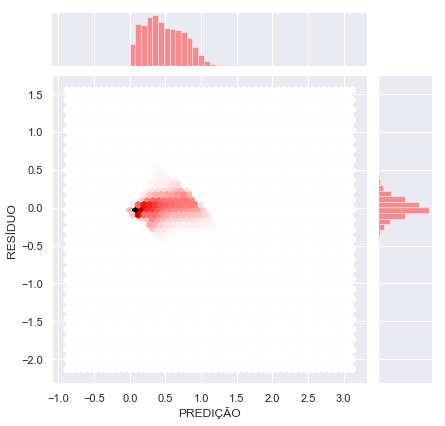

In [ ]:
lr_residuo = lr_avaliacao[Target]-lr_avaliacao['prediction']
ax1 = sns.jointplot(lr_avaliacao['prediction'],lr_residuo, kind="hex", color="red")
ax1.set_axis_labels("PREDIÇÃO", 'RESÍDUO');

Acima, têm-se o gráfico do resíduo da predição. É possível perceber uma grande densidade de dados em torno do eixo zero, onde observa-se que o erro de predição se comporta como uma distribuição normal centralizada em zero (evidenciada no histograma exposto na barra lateral).

In [ ]:
print('Avaliação estatística do resíduo:')
round(lr_residuo.describe().to_frame(),3)

Avaliação estatística do resíduo:


0
count  1322819.000
mean  -0.000      
std    0.135      
min   -2.135      
25%   -0.075      
50%   -0.005      
75%    0.079      
max    1.551

### Aplicando Regressão Linear Generalizada

In [ ]:
# ------------------------------ REGRESSÃO LINEAR GENERALIZADA COM GRIDSEACH---------------------------#

#Definindo o estimador para Regressão Linear Generalizada
glr = GeneralizedLinearRegression(featuresCol = 'features', labelCol=Target, maxIter=20,linkPredictionCol="p")

#Incluindo os elementos do pipeline para o estimador
glr_pipeline = Pipeline(stages=[glr])

#Criando a configuração de parametros para testes do pipeline
glr_paramGrid = ParamGridBuilder() \
    .addGrid(glr.family, ['gaussian']) \
    .addGrid(glr.link, ['identity']) \
    .addGrid(glr.regParam, [0.01,0.5]) \
    .addGrid(glr.maxIter, [10,20,50]) \
    .build()

#Utilizando crossvalidator, podemos utilizar o Pipeline como um estimador, o paramGrid com conjuto de parametros
#para este estimador e definimos o método de validação para definir o melhor conjunto de parametros.
crossVal = CrossValidator(estimator=glr_pipeline,
                           estimatorParamMaps=glr_paramGrid,
                           evaluator=RegressionEvaluator(labelCol=Target, metricName='r2'),
                           numFolds=2)

#Executando o algoritmo de crossvalidação com base no elementos configurados anteriormente
glr_cvModel = crossVal.fit(train_df)

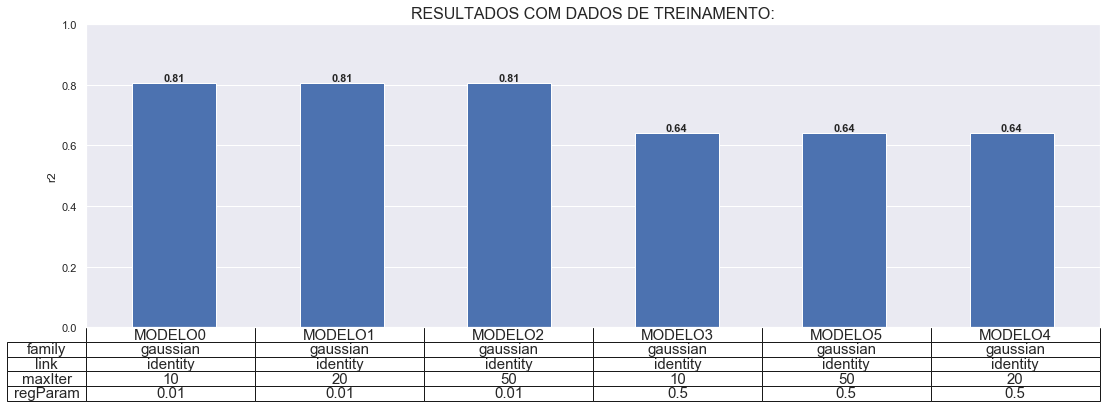

In [ ]:
# Verificando os resultados com os dados de treinamento
#Listando as combinações de parametros utilizados em cada modelo
params = [{p.name: v for p, v in m.items()} for m in glr_cvModel.getEstimatorParamMaps()]

#Listando o resultado e agrupando em um dataframe
glr_resultado = pd.DataFrame.from_dict([
    {glr_cvModel.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, glr_cvModel.avgMetrics)
])
#Ordenando o daframe dos resultados pelos resultados para plot
glr_resultado = glr_resultado.sort_values(glr_cvModel.getEvaluator().getMetricName(), ascending=False)

#Criando Figure para os plots
fig = plt.figure(figsize=(15,10));

#Plot do resultado com os dados de treinamento
ax1 = plt.subplot2grid((2, 1), (0, 0), colspan=1,rowspan=1)
xlabels = ['MODELO'+str(i) for i in glr_resultado.index]
bars = ax1.bar(xlabels,glr_resultado[glr_cvModel.getEvaluator().getMetricName()],0.5)
ax1.set_title('RESULTADOS COM DADOS DE TREINAMENTO:',fontsize = 16)
ax1.set_ylabel(glr_cvModel.getEvaluator().getMetricName())
plt.xticks([])
plt.ylim(0,1)

#Inserindo texto da contagem em cada barra do gráfico
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, f'{height:.2f}', ha='center', va='bottom',fontweight='bold', fontsize=11)

# Removendo a coluna da medida de desempenho já que vai ser desnecessária na tabela
glr_resultado = glr_resultado.drop(columns=[glr_cvModel.getEvaluator().getMetricName()])

#Plotando a tabela com os valores dos parametros
tabela_resultados = plt.table(cellText=glr_resultado.values.T,
                    rowLabels=glr_resultado.columns,
                    colLabels=xlabels,
                    cellLoc= 'center',
                    rowLoc = 'center',
                    loc='bottom')

tabela_resultados.set_fontsize(15)

#Ajustando as bordas dos gráficos
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Resultados com os dados de Teste
r2: 0.81


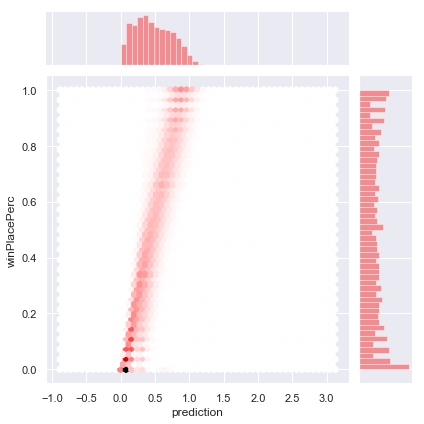

In [ ]:
#Realizando a avaliação com os dados de teste
glr_validacao = glr_cvModel.transform(test_df)

#Definindo instancia do elemento para avaliar o estimador
glr_avaliacao = RegressionEvaluator(predictionCol="prediction",labelCol=Target,metricName="r2")

#Apresentação dos resultados com os dados de teste
r2_test = glr_avaliacao.evaluate(glr_validacao)
print("Resultados com os dados de Teste")
print(glr_cvModel.getEvaluator().getMetricName()+":", round(r2_test,2))

#Selecionando somente as colunas dos valores preditos e observador para plot dos resultados
glr_avaliacao = glr_validacao.toPandas()
glr_avaliacao = glr_avaliacao[[Target,'prediction']]

#Plot dos valores preditos x valores observados
ax1 = sns.jointplot(glr_avaliacao['prediction'],glr_avaliacao[Target],kind="hex", color="red",)
plt.show()


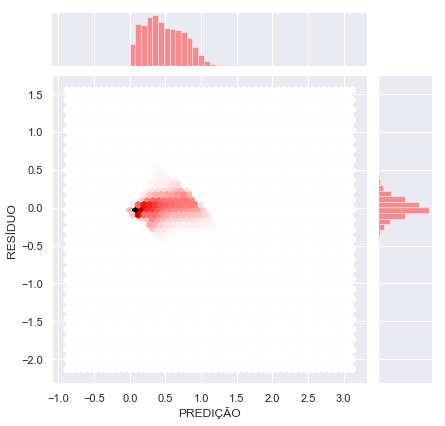

In [ ]:
glr_residuo = glr_avaliacao[Target]-glr_avaliacao['prediction']
ax1 = sns.jointplot(glr_avaliacao['prediction'],glr_residuo, kind="hex", color="red")
ax1.set_axis_labels("PREDIÇÃO", 'RESÍDUO');

In [ ]:
print('Avaliação estatística do resíduo:')
round(glr_residuo.describe().to_frame(),3)

Avaliação estatística do resíduo:


0
count  1322819.000
mean  -0.000      
std    0.135      
min   -2.135      
25%   -0.075      
50%   -0.005      
75%    0.079      
max    1.551

### Aplicando Random Forest

In [ ]:
# ------------------------------ RANDOM FOREST COM GRIDSEACH ---------------------------#

#Definindo o estimador para Gradient-Boosted Trees
rf = RandomForestRegressor(featuresCol = 'features', labelCol=Target, seed=42)

#Incluindo os elementos do pipeline para o estimador
rf_pipeline = Pipeline(stages=[rf])

#Criando a configuração de parametros para testes do pipeline
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [5]) \
    .addGrid(rf.maxDepth, [5]) \
    .addGrid(rf.maxBins, [5]) \
    .build()

#Utilizando crossvalidator, podemos utilizar o Pipeline como um estimador, o paramGrid com conjuto de parametros
#para este estimador e definimos o método de validação para definir o melhor conjunto de parametros.
crossVal = CrossValidator(estimator=rf_pipeline,
                           estimatorParamMaps=rf_paramGrid,
                           evaluator=RegressionEvaluator(labelCol=Target,metricName="r2"),
                           numFolds=2)

#Executando o algoritmo de crossvalidação com base no elementos configurados anteriormente
rf_cvModel = crossVal.fit(train_df)

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\ProgramData\Anaconda3\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "C:\ProgramData\Anaconda3\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\ProgramData\Anaconda3\lib\socketserver.py", line 720, in __init__
    self.handle()
  File "C:\spark\spark-2.4.3-bin-hadoop2.7\python\pyspark\accumulators.py", line 269, in handle
    poll(accum_updates)
  File "C:\spark\spark-2.4.3-bin-hadoop2.7\python\pyspark\accumulators.py", line 241, in poll
    if func():
  File "C:\spark\spark-2.4.3-bin-hadoop2.7\python\pyspark\accumulators.py", line 245, in accum_updates
    num_updates = read_int(self.rfile)
  File "C:\spark\spark-2.4.3-bin-hadoop2.7\python\pyspark\serializers.py", line 7

In [ ]:
# Verificando os resultados com os dados de treinamento
#Listando as combinações de parametros utilizados em cada modelo
params = [{p.name: v for p, v in m.items()} for m in rf_cvModel.getEstimatorParamMaps()]

#Listando o resultado e agrupando em um dataframe
rf_resultado = pd.DataFrame.from_dict([
    {rf_cvModel.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, glr_cvModel.avgMetrics)
])
#Ordenando o daframe dos resultados pelos resultados para plot
rf_resultado = rf_resultado.sort_values(rf_cvModel.getEvaluator().getMetricName(), ascending=False)

#Criando Figure para os plots
fig = plt.figure(figsize=(15,10));

#Plot do resultado com os dados de treinamento
ax1 = plt.subplot2grid((2, 1), (0, 0), colspan=1,rowspan=1)
xlabels = ['MODELO'+str(i) for i in rf_resultado.index]
bars = ax1.bar(xlabels,rf_resultado[rf_cvModel.getEvaluator().getMetricName()],0.5)
ax1.set_title('RESULTADOS COM DADOS DE TREINAMENTO:',fontsize = 16)
ax1.set_ylabel(rf_cvModel.getEvaluator().getMetricName())
plt.xticks([])
plt.ylim(0,1)

#Inserindo texto da contagem em cada barra do gráfico
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, f'{height:.2f}', ha='center', va='bottom',fontweight='bold', fontsize=11)

# Removendo a coluna da medida de desempenho já que vai ser desnecessária na tabela
rf_resultado = rf_resultado.drop(columns=[rf_cvModel.getEvaluator().getMetricName()])

#Plotando a tabela com os valores dos parametros
tabela_resultados = plt.table(cellText=rf_resultado.values.T,
                    rowLabels=rf_resultado.columns,
                    colLabels=xlabels,
                    cellLoc= 'center',
                    rowLoc = 'center',
                    loc='bottom')

tabela_resultados.set_fontsize(15)

#Ajustando as bordas dos gráficos
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
#Realizando a avaliação com os dados de teste
rf_validacao = rf_cvModel.transform(test_df)

#Definindo instancia do elemento para avaliar o estimador
rf_avaliacao = RegressionEvaluator(predictionCol="prediction",labelCol=Target,metricName="r2")

#Apresentação dos resultados com os dados de teste
r2_test = rf_avaliacao.evaluate(rf_validacao)
print("Resultados com os dados de Teste")
print(rf_cvModel.getEvaluator().getMetricName()+":", round(r2_test,2))

#Selecionando somente as colunas dos valores preditos e observador para plot dos resultados
rf_avaliacao = rf_validacao.toPandas()
rf_avaliacao = rf_avaliacao[[Target,'prediction']]

#Plot dos valores preditos x valores observados
ax1 = sns.jointplot(rf_avaliacao['prediction'],rf_avaliacao[Target],kind="hex", color="red",)
plt.show()

In [ ]:
rf_residuo = rf_avaliacao[Target]-rf_avaliacao['prediction']
ax1 = sns.jointplot(rf_avaliacao['prediction'],rf_residuo, kind="hex", color="red")
ax1.set_axis_labels("PREDIÇÃO", 'RESÍDUO');

In [ ]:
print('Avaliação estatística do resíduo:')
round(rf_residuo.describe().to_frame(),3)

### Aplicando o Gradient Boosted Tree

In [ ]:
# ------------------------------ GRADIENT BOOSTED TREE COM GRIDSEACH ---------------------------#

#Definindo o estimador para Gradient-Boosted Trees
gbt = GBTRegressor(featuresCol = 'features', labelCol=Target, maxIter=5, seed=42)

#Incluindo os elementos do pipeline para o estimador
gbt_pipeline = Pipeline(stages=[gbt])

#Criando a configuração de parametros para testes do pipeline
#possibilidades featureSubsetStrategy: 'all','sqrt','onethird','log2'
gbt_paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5,10]) \
    .addGrid(gbt.maxBins, [5,10,50]) \
    .addGrid(gbt.minInstancesPerNode,[2]) \
    .addGrid(gbt.featureSubsetStrategy, ['all','log2','sqrt']) \
    .build()

#Utilizando crossvalidator, podemos utilizar o Pipeline como um estimador, o paramGrid com conjuto de parametros
#para este estimador e definimos o método de validação para definir o melhor conjunto de parametros.
crossVal = CrossValidator(estimator=gbt_pipeline,
                           estimatorParamMaps=gbt_paramGrid,
                           evaluator=RegressionEvaluator(labelCol=Target,metricName="r2"),
                           numFolds=2)

#Executando o algoritmo de crossvalidação com base no elementos configurados anteriormente
gbt_cvModel = crossVal.fit(train_df)


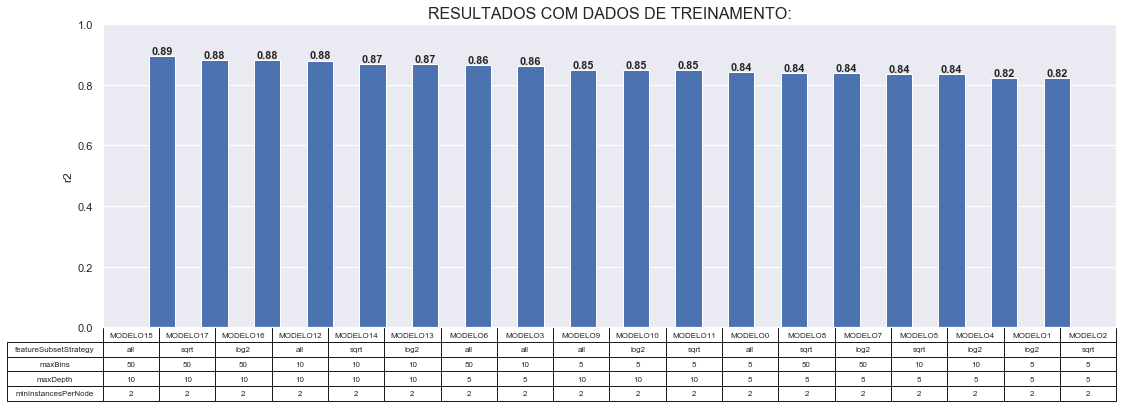

In [ ]:
# Verificando os resultados com os dados de treinamento
#Listando as combinações de parametros utilizados em cada modelo
params = [{p.name: v for p, v in m.items()} for m in gbt_cvModel.getEstimatorParamMaps()]

#Listando o resultado e agrupando em um dataframe
gbt_resultado = pd.DataFrame.from_dict([
    {gbt_cvModel.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, gbt_cvModel.avgMetrics)
])
#Ordenando o daframe dos resultados pelos resultados para plot
gbt_resultado = gbt_resultado.sort_values(gbt_cvModel.getEvaluator().getMetricName(), ascending=False)

#Criando Figure para os plots
fig = plt.figure(figsize=(15,10));

#Plot do resultado com os dados de treinamento
ax1 = plt.subplot2grid((2, 1), (0, 0), colspan=1,rowspan=1)
xlabels = ['MODELO'+str(i) for i in gbt_resultado.index]
bars = ax1.bar(xlabels,gbt_resultado[gbt_cvModel.getEvaluator().getMetricName()],0.5)
ax1.set_title('RESULTADOS COM DADOS DE TREINAMENTO:',fontsize = 16)
ax1.set_ylabel(gbt_cvModel.getEvaluator().getMetricName())
plt.xticks([])
plt.ylim(0,1)

#Inserindo texto da contagem em cada barra do gráfico
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, f'{height:.2f}', ha='center', va='bottom',fontweight='bold', fontsize=11)

# Removendo a coluna da medida de desempenho já que vai ser desnecessária na tabela
gbt_resultado = gbt_resultado.drop(columns=[gbt_cvModel.getEvaluator().getMetricName()])

#Plotando a tabela com os valores dos parametros
tabela_resultados = plt.table(cellText=gbt_resultado.values.T,
                    rowLabels=gbt_resultado.columns,
                    colLabels=xlabels,
                    cellLoc= 'center',
                    rowLoc = 'center',
                    loc='bottom')

tabela_resultados.set_fontsize(15)

#Ajustando as bordas dos gráficos
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Resultados com os dados de Teste
R2: 0.8944339724762915


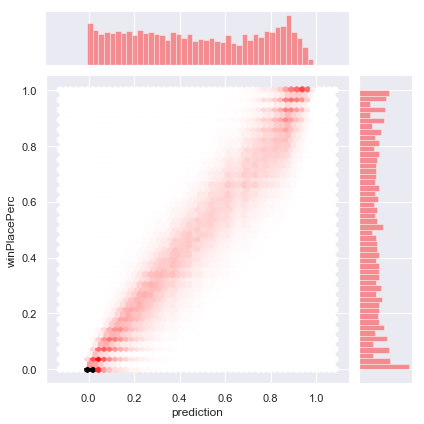

In [ ]:
#Aplicando dados de teste no modelo encontrado
gbt_validacao = gbt_cvModel.transform(test_df)

#Definindo instancia do elemento para avaliar o estimador
gbt_avaliacao = RegressionEvaluator(predictionCol="prediction",labelCol=Target,metricName="r2")

#Apresentação dos resultados com os dados de teste
r2_test = gbt_avaliacao.evaluate(gbt_validacao)
print("Resultados com os dados de Teste")
print("R2:", r2_test)

#Selecionando somente as colunas dos valores preditos e observador para plot dos resultados
gbt_avaliacao = gbt_validacao.toPandas()
gbt_avaliacao = gbt_avaliacao[[Target,'prediction']]

#Plot dos Valores Preditos x Valores Observados
ax1 = sns.jointplot(gbt_avaliacao['prediction'],gbt_avaliacao[Target],kind="hex", color="red",)
plt.show()

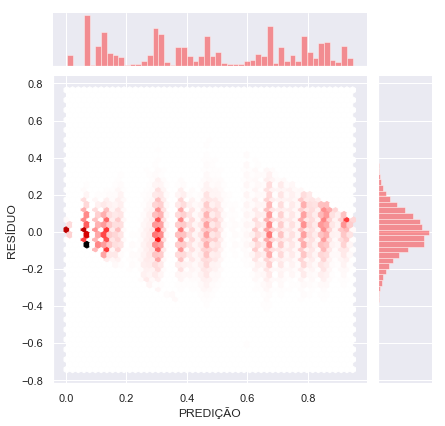

In [ ]:
gbt_residuo = gbt_avaliacao[Target]-gbt_avaliacao['prediction']
ax1 = sns.jointplot(gbt_avaliacao['prediction'],gbt_residuo, kind="hex", color="red")
ax1.set_axis_labels("PREDIÇÃO", 'RESÍDUO');

In [ ]:
print('Avaliação estatística do resíduo:')
round(gbt_residuo.describe().to_frame(),3)

Avaliação estatística do resíduo:


0
count  1322819.000
mean  -0.000      
std    0.123      
min   -0.744      
25%   -0.068      
50%   -0.002      
75%    0.074      
max    0.764

## Conclusão

### Comparação entre os métodos

In [ ]:
#Criando Figure para os plots
fig = plt.figure(figsize=(15,10));

#Plot para comparação entre os melhores modelos por tipo de estimador
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1,rowspan=1)

xlabels = ['lr','glr','rf','gbt']

#ATENÇÃO: Aqui é preciso garantir que todas as métricas de desempenho são iguais. Para este trabalho, foi utilizado R²
desempenhoEstimadores = [lr_avaliacao.evaluate(gbt_validacao),
                         glr_avaliacao.evaluate(gbt_validacao),
                         rf_avaliacao.evaluate(gbt_validacao),
                         gbt_avaliacao.evaluate(gbt_validacao)]

bars = ax1.bar(xlabels,desempenhoEstimadores,0.5)
ax1.set_title('COMPARAÇÃO POR TIPO DE ESTIMADOR',fontsize = 16)
ax1.set_ylabel(gbt_cvModel.getEvaluator().getMetricName())
plt.xticks([])
plt.ylim(0,1)

result = pd.concat([round(lr_residuo.describe().to_frame(),3), 
                    round(glr_residuo.describe().to_frame(),3)
                   round(rf_residuo.describe().to_frame(),3)
                   round(gbt_residuo.describe().to_frame(),3)], axis=1, sort=False)
result.head(10)

O presente trabalho teve como principal objetivo a criação de um modelo para previsão da colocação final de jogadores, em uma escala de 1 (primeiro lugar) a 0 (último lugar), do jogo PUBG com base em suas estatísticas finais.
Esse é um problema que claramente pode ser resolvido aplicando diferentes métodos de Regressão.

Primeiramente, foi realizado um estudo do Processo, de forma a garantir o conhecimento de todos os integrantes da equipe com relação ao funcionamento do jogo, suas regras e características principais.
Posteriormente, foi desenvolvido um código seguindo todo o KDD de Mineração de Dados, a saber: Seleção, Pré-processamento, Transformação, Mineração, Interpretação/Avaliação.

Durante a avaliação exploratória dos dados, foi possível perceber a distinção entre o comportamento de jogadores com boas colocações e jogadores com colocações ruins. Alguns atributos que se destacaram nesse sentido foram principalemnte walkDistance, killPlace, heals, assistis, e boosts.

Com base no exposto acima e nos resultados apresentados ao longo deste Notebook, podemos considerar que o modelo utilizando o método Gradiente Boosted Tree obteve um melhor desempenho frente aos outros métodos com R² de 0.89 e desvio padrão do erro 0.12.



## Trabalhos futuros

É importante notar que ainda há espaço para melhoria deste modelo. Seguem alguns pontos levantados para avaliação em trabalhos futuros:

1) Avaliar utilização do resultado do PCA como entrada dos modelos

2) Seleção de parâmetros utilizando RandomSearch

3) Seleção de parâmetros utilizando Otimização Bayseana

4) Avaliar restrição de domínio para valores preditos pelos estimadores

5) Avaliar formas de plot gráfico sem a necessidade de converter do DataFrame Pyspark para Pandas

6) Submeter no Kaggle e verificar a pontuação